# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings
import warnings



In [2]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.3.4
pandas version: 2.3.2
matplotlib version: 3.10.6
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [4]:
#Try loading one file

df = pd.read_parquet('../data_NYC_Taxi/trip_records/2023-1.parquet')
print("Number of rows:", len(df))
df.info()

# rows_9_to_10 = df[
#     (df["tpep_pickup_datetime"].dt.hour >= 9) &
#     (df["tpep_pickup_datetime"].dt.hour < 10)
# ]
# print("few rows between 9 and 10 AM:", rows_9_to_10.sort_values(by='tpep_pickup_datetime').head(50).to_string())
# print("Number of rows between 9 and 10 AM:", len(rows_9_to_10))

Number of rows: 3041714
<class 'pandas.core.frame.DataFrame'>
Index: 3041714 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  air

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [5]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [6]:
# from google.colab import 
#File is read from the local system
# drive.mount('/content/drive')

In [7]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/home/sirkumar/IIITB/EDA//data_NYC_Taxi/trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file. Each Parquet file has data for one month only
        print(f"Reading file: {file_name}")
        monthly_df = pd.read_parquet(file_path)
       
        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        unique_dates = monthly_df["tpep_pickup_datetime"].dt.date.unique()
        for date in unique_dates: 
            #For every day
            daily_df = monthly_df[monthly_df["tpep_pickup_datetime"].between(f"{date} 00:00:00", f"{date} 23:59:59")]

            # Iterate through each hour of the selected date
            for hour in range(24):
                hourly_df = daily_df[daily_df["tpep_pickup_datetime"].between(f"{date} {hour:02d}:00:00", f"{date} {hour:02d}:59:59")]

                # Sample 5% of the hourly data randomly
                if not hourly_df.empty:
                    sampled_hour = hourly_df.sample(frac=0.05, random_state=42)
                    
                    # add data of this hour to the dataframe
                    sampled_data = pd.concat([sampled_data, sampled_hour], ignore_index=True)


        # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat([df, sampled_data], ignore_index=True)
        print(f"After processing file {file_name}, the cumulative dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

Reading file: 2023-8.parquet
After processing file 2023-8.parquet, the cumulative dataframe has 143782 rows and 19 columns.
Reading file: 2023-12.parquet
After processing file 2023-12.parquet, the cumulative dataframe has 310491 rows and 19 columns.
Reading file: 2023-1.parquet
After processing file 2023-1.parquet, the cumulative dataframe has 462578 rows and 20 columns.
Reading file: 2023-2.parquet
After processing file 2023-2.parquet, the cumulative dataframe has 631274 rows and 20 columns.
Reading file: 2023-10.parquet
After processing file 2023-10.parquet, the cumulative dataframe has 805529 rows and 20 columns.
Reading file: 2023-9.parquet
After processing file 2023-9.parquet, the cumulative dataframe has 946404 rows and 20 columns.
Reading file: 2023-5.parquet
After processing file 2023-5.parquet, the cumulative dataframe has 1090862 rows and 20 columns.
Reading file: 2023-7.parquet
After processing file 2023-7.parquet, the cumulative dataframe has 1264930 rows and 20 columns.
Re

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [8]:
# Store the df in csv/parquet
# Remove existing file if any
if os.path.exists('/home/sirkumar/IIITB/EDA/sampled_nyc_data_2023.parquet'):
    os.remove('/home/sirkumar/IIITB/EDA/sampled_nyc_data_2023.parquet')
    
df.to_parquet('/home/sirkumar/IIITB/EDA/sampled_nyc_data_2023.parquet', index=False)

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [9]:
# Load the new data file
df = pd.read_parquet('/home/sirkumar/IIITB/EDA/sampled_nyc_data_2023.parquet')
print("Number of rows in the sampled data:", len(df))


Number of rows in the sampled data: 1896400


In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
0,2,2023-07-01 00:16:20,2023-07-01 00:49:22,1.0,10.93,1.0,N,132,61,1,47.1,1.0,0.5,10.27,0.0,1.0,61.62,0.0,1.75,NaN
1,2,2023-07-01 00:00:15,2023-07-01 00:31:42,1.0,10.49,1.0,N,230,95,1,45.7,1.0,0.5,4.00,0.0,1.0,54.70,2.5,0.00,NaN
2,2,2023-07-01 00:51:04,2023-07-01 00:56:50,1.0,1.42,1.0,N,107,162,1,8.6,1.0,0.5,2.72,0.0,1.0,16.32,2.5,0.00,NaN
3,2,2023-07-01 00:37:46,2023-07-01 00:45:30,3.0,1.10,1.0,N,249,79,1,9.3,1.0,0.5,2.86,0.0,1.0,17.16,2.5,0.00,NaN
4,2,2023-07-01 00:00:34,2023-07-01 00:16:34,1.0,3.20,1.0,N,142,41,1,18.4,1.0,0.5,4.68,0.0,1.0,28.08,2.5,0.00,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [12]:
# Fix the index and drop any columns that are not needed
#In next cell airport_fee is dropped as it has null values only



**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [13]:
# Combine the two airport fee columns
print("Unique values in Airport_fee column:", df['Airport_fee'].unique())
print("Unique values in airport_fee column:", df['airport_fee'].unique())

# Count null/empty values in Airport_fee
print("\nNumber of null/empty rows in Airport_fee:", df['Airport_fee'].isna().sum())
print("Number of null/empty rows in airport_fee:", df['airport_fee'].isna().sum())

# Since Airport_fee has fewer nulls, fill its NaN values with values from airport_fee
df['Airport_fee'] = df['Airport_fee'].fillna(df['airport_fee'])
print("After filling, number of null/empty rows in Airport_fee:", df['Airport_fee'].isna().sum())
# Drop the airport_fee column
df = df.drop(columns=['airport_fee'])
df.info()



Unique values in Airport_fee column: [ 1.75  0.     nan  1.   -1.75  1.25 -1.25]
Unique values in airport_fee column: [  nan  1.25  0.   -1.25]

Number of null/empty rows in Airport_fee: 213357
Number of null/empty rows in airport_fee: 1747917
After filling, number of null/empty rows in Airport_fee: 64874
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra           

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [14]:
# check where values of fare amount are negative
numeric_cols =['fare_amount', 'total_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge']
RateCodeID = {
1 : "Standard rate",
2 : "JFK",
3 : "Newark",
4 : "Nassau or Westchester",
5 : "Negotiated fare",
6 : "Group ride"
}

Payment_type = {
1 : "Credit card",
2 : "Cash",
3 : "No charge",
4 : "Dispute",
5 : "Unknown",
6 : "Voided trip"
}

df = df[df['payment_type'] != 4]  # Filtering for 'Dispute' payment type

for col in numeric_cols:
    print (f"Checking column: {col}")
    negative_values = df[df[col] < 0]
    print(f"\n{col} - Found {len(negative_values)} negative values")

    #convert negative values to positive
    if len(negative_values) > 0:
        print(f"Converting negative values in column: {col} to positive")
        df.loc[df[col] < 0, col] = df.loc[df[col] < 0, col].abs()
        
        # Verify if any negative values remain
        negative_values = df[df[col] < 0]
        print(f"After conversion, {col} - Found {len(negative_values)} negative values")
        
       

Checking column: fare_amount

fare_amount - Found 0 negative values
Checking column: total_amount

total_amount - Found 75 negative values
Converting negative values in column: total_amount to positive
After conversion, total_amount - Found 0 negative values
Checking column: extra

extra - Found 3 negative values
Converting negative values in column: extra to positive
After conversion, extra - Found 0 negative values
Checking column: mta_tax

mta_tax - Found 71 negative values
Converting negative values in column: mta_tax to positive
After conversion, mta_tax - Found 0 negative values
Checking column: tip_amount

tip_amount - Found 0 negative values
Checking column: tolls_amount

tolls_amount - Found 0 negative values
Checking column: improvement_surcharge

improvement_surcharge - Found 75 negative values
Converting negative values in column: improvement_surcharge to positive
After conversion, improvement_surcharge - Found 0 negative values
Checking column: congestion_surcharge

conges

Did you notice something different in the `RatecodeID` column for above records?

In [15]:
# Find which columns have negative values

for col in numeric_cols:
    negative_values = df[df[col] < 0]
    if not negative_values.empty:
        print(f"Column '{col}' has {len(negative_values)} negative values.")



In [16]:
# fix these negative values
# convert negative values to absolute values
for col in numeric_cols:
    if ( df[col] < 0 ).any():
        df[col] = df[col].abs()
        print(f"Converted negative values in column '{col}' to absolute values.")

# verify no negative values remain
for col in numeric_cols:
    negative_values = df[df[col] < 0]
    if negative_values.empty:
        print(f"Column '{col}' has no negative values remaining.")

Column 'fare_amount' has no negative values remaining.
Column 'total_amount' has no negative values remaining.
Column 'extra' has no negative values remaining.
Column 'mta_tax' has no negative values remaining.
Column 'tip_amount' has no negative values remaining.
Column 'tolls_amount' has no negative values remaining.
Column 'improvement_surcharge' has no negative values remaining.
Column 'congestion_surcharge' has no negative values remaining.


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [17]:
# Find the proportion of missing values in each column
columns = df.columns
missing_values_cols = []
for col in columns:
    missing_count = df[col].isnull().sum()
    total_count = len(df[col])
    
    if missing_count == 0:
        print(f"Column '{col}': No missing values.")
        continue
    
    missing_percentage = (missing_count / total_count) * 100

    print(f"Column '{col}': Missing Values = {missing_count}, Total cound = {total_count}, Percentage = {missing_percentage:.2f}%")
    missing_values_cols.append((col))

print("Columns with missing values:", missing_values_cols)


Column 'VendorID': No missing values.
Column 'tpep_pickup_datetime': No missing values.
Column 'tpep_dropoff_datetime': No missing values.
Column 'passenger_count': Missing Values = 64874, Total cound = 1882715, Percentage = 3.45%
Column 'trip_distance': No missing values.
Column 'RatecodeID': Missing Values = 64874, Total cound = 1882715, Percentage = 3.45%
Column 'store_and_fwd_flag': Missing Values = 64874, Total cound = 1882715, Percentage = 3.45%
Column 'PULocationID': No missing values.
Column 'DOLocationID': No missing values.
Column 'payment_type': No missing values.
Column 'fare_amount': No missing values.
Column 'extra': No missing values.
Column 'mta_tax': No missing values.
Column 'tip_amount': No missing values.
Column 'tolls_amount': No missing values.
Column 'improvement_surcharge': No missing values.
Column 'total_amount': No missing values.
Column 'congestion_surcharge': Missing Values = 64874, Total cound = 1882715, Percentage = 3.45%
Column 'Airport_fee': Missing Val

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [18]:
# Take the mean of the passenger_count column and fill the NaN values with the mean
mean = df['passenger_count'].mean()
print("Before imputation, number of null/empty rows in passenger_count:", df['passenger_count'].isna().sum())
df['passenger_count'] = df['passenger_count'].fillna(round(mean))
print("After imputation, number of null/empty rows in passenger_count:", df['passenger_count'].isna().sum())

# check negative counts in passenger_count
negative_passenger_counts = df[df['passenger_count'] < 0]
print("\nNumber of negative values in passenger_count column:", len(negative_passenger_counts))

#check for zero values in passenger_count with non-zero trip distance
zero_passenger_counts = df[(df['passenger_count'] == 0) & (df['trip_distance'] > 0)]
#remove these rows
print("\nNumber of zero passenger count with non-zero trip distance before removal:", len(zero_passenger_counts))
df = df.drop(zero_passenger_counts.index)
print("Number of zero passenger count with non-zero trip distance after removal:", len(df))


Before imputation, number of null/empty rows in passenger_count: 64874
After imputation, number of null/empty rows in passenger_count: 0

Number of negative values in passenger_count column: 0

Number of zero passenger count with non-zero trip distance before removal: 28655
Number of zero passenger count with non-zero trip distance after removal: 1854060


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [19]:
# Fix missing values in 'RatecodeID'
print("Number of null/empty rows in RatecodeID before imputation:", df['RatecodeID'].isna().sum())
# Remove rows with null RatecodeID
df = df.dropna(subset=['RatecodeID'])
print("After dropping, number of null/empty rows in RatecodeID:", df['RatecodeID'].sum())




Number of null/empty rows in RatecodeID before imputation: 64874
After dropping, number of null/empty rows in RatecodeID: 2948119.0


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [20]:
# handle null values in congestion_surcharge

print("Number of null/empty rows in congestion_surcharge before imputation:", df['congestion_surcharge'].isna().sum())
# Impute NaN values in 'congestion_surcharge' with 0
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)
print("After imputation, number of null/empty rows in congestion_surcharge:", df['congestion_surcharge'].isna().sum())




Number of null/empty rows in congestion_surcharge before imputation: 0
After imputation, number of null/empty rows in congestion_surcharge: 0


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [21]:
# Handle any remaining missing values
cols = df.columns
for col in cols:
    print(f"Column: {col}:", end='') #Do not inser newline character 
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"Handling remaining missing values in column '{col}'")
    else:
        print(f"No missing values")

#Verify no negative values remain in numeric columns
cols = numeric_cols + ['passenger_count', 'RatecodeID', 'congestion_surcharge']
for col in cols:
    negative_values = df[df[col] < 0]
    if not negative_values.empty:
        print(f"Column {col}: {len(negative_values)} negative values.")
    else:
        print(f"Column {col}: No negative values.")

#Check RatecodeID is within valid range
invalid_ratecodeid = df[~df['RatecodeID'].isin([1, 2, 3, 4, 5, 6])]
if invalid_ratecodeid.empty:
    print("All RatecodeID values are valid.")
else:
    print(f"Number of invalid RatecodeID values: {len(invalid_ratecodeid)}")
    #drop these rows
    df = df.drop(invalid_ratecodeid.index)
    print("After dropping, number of invalid RatecodeID values:", len(df))

#Check payment_type is within valid range
invalid_payment_type = df[~df['payment_type'].isin([1, 2, 3, 4, 5, 6])]
if invalid_payment_type.empty:
    print("All payment_type values are valid.")
else:
    print(f"Number of invalid payment_type values: {len(invalid_payment_type)}")
    #drop these rows
    df = df.drop(invalid_payment_type.index)
    print("After dropping, number of invalid payment_type values:", len(df))


Column: VendorID:No missing values
Column: tpep_pickup_datetime:No missing values
Column: tpep_dropoff_datetime:No missing values
Column: passenger_count:No missing values
Column: trip_distance:No missing values
Column: RatecodeID:No missing values
Column: store_and_fwd_flag:No missing values
Column: PULocationID:No missing values
Column: DOLocationID:No missing values
Column: payment_type:No missing values
Column: fare_amount:No missing values
Column: extra:No missing values
Column: mta_tax:No missing values
Column: tip_amount:No missing values
Column: tolls_amount:No missing values
Column: improvement_surcharge:No missing values
Column: total_amount:No missing values
Column: congestion_surcharge:No missing values
Column: Airport_fee:No missing values
Column fare_amount: No negative values.
Column total_amount: No negative values.
Column extra: No negative values.
Column mta_tax: No negative values.
Column tip_amount: No negative values.
Column tolls_amount: No negative values.
Column

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [22]:
# Describe the data and check if there are any potential outliers present


df.describe



<bound method NDFrame.describe of          VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-07-01 00:16:20   2023-07-01 00:49:22              1.0   
1               2  2023-07-01 00:00:15   2023-07-01 00:31:42              1.0   
2               2  2023-07-01 00:51:04   2023-07-01 00:56:50              1.0   
3               2  2023-07-01 00:37:46   2023-07-01 00:45:30              3.0   
4               2  2023-07-01 00:00:34   2023-07-01 00:16:34              1.0   
...           ...                  ...                   ...              ...   
1896394         2  2023-06-30 23:19:44   2023-06-30 23:32:53              1.0   
1896395         2  2023-06-30 23:53:10   2023-07-01 00:05:55              1.0   
1896397         1  2023-06-30 23:50:42   2023-07-01 00:20:00              2.0   
1896398         1  2023-06-30 23:05:31   2023-06-30 23:15:52              1.0   
1896399         2  2023-07-01 00:00:51   2023-07-01 00:24:19              1

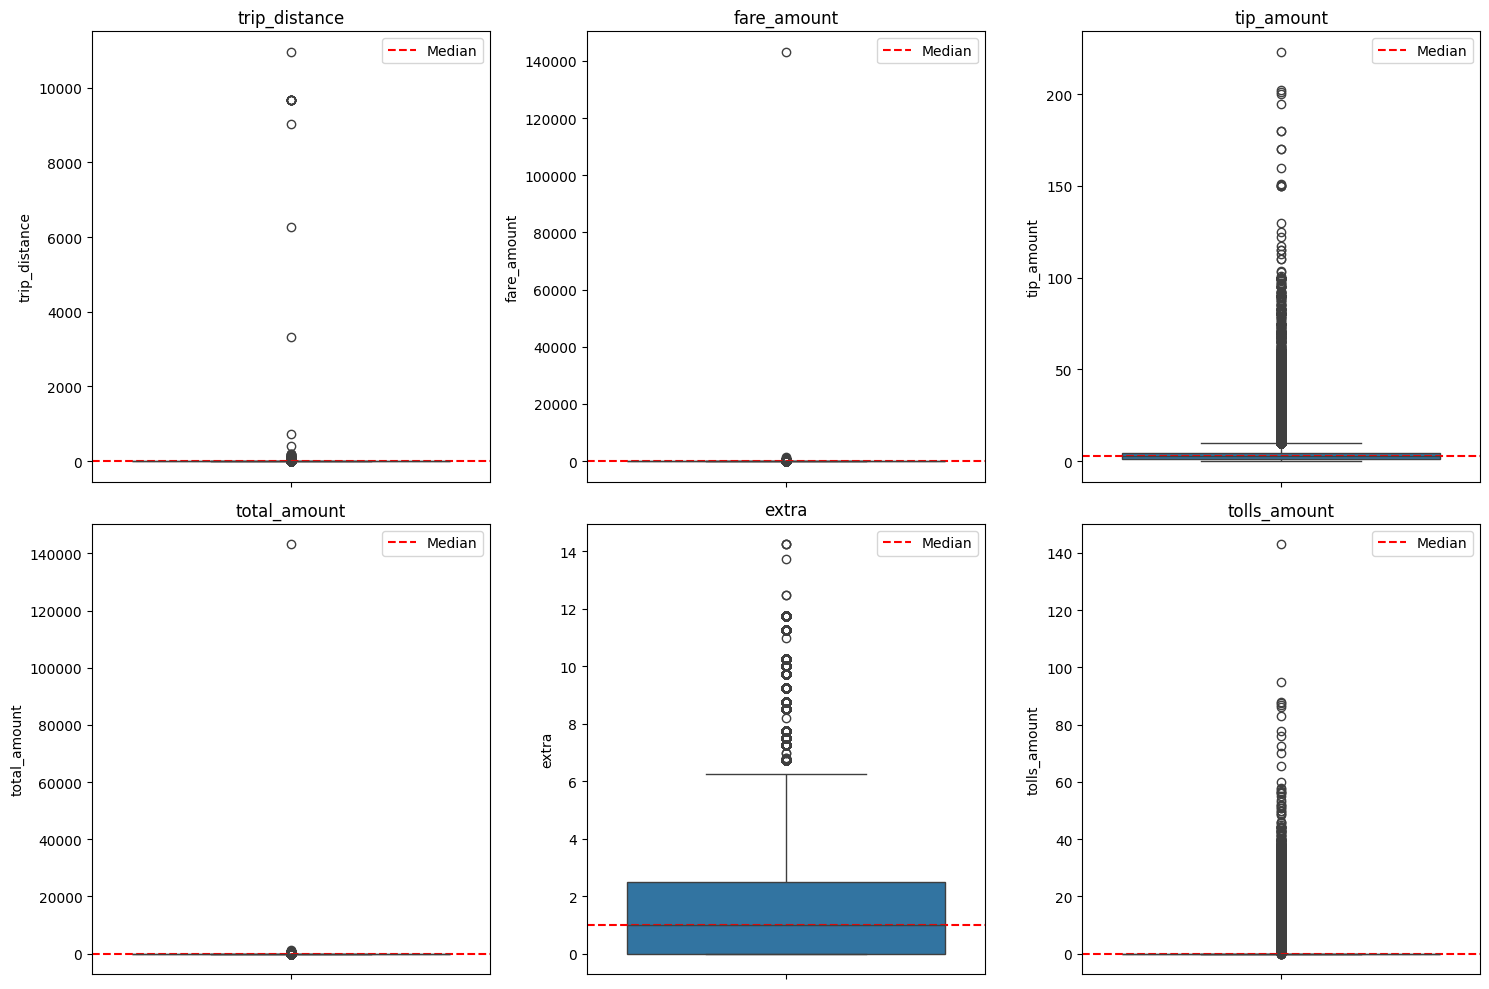

In [23]:
# Check for potential out of place values in various columns
cols_to_check = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'extra', 'tolls_amount']

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
    median_val = df[col].median()
    plt.axhline(median_val, color='r', linestyle='--', label='Median')
    plt.legend()
plt.tight_layout()

plt.show()

In [24]:
#From the figure above, we can see that there are potential outliers in fare_amount, tip_amount, total_amount, extra, tolls_amount columns.
#We will handle these outliers in the next steps.
# Handle outliers using IQR method
cols_to_check = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'extra']
for col in cols_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the dataframe to remove outliers
    before_rows = len(df)
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    after_rows = len(df)
    print(f"Column '{col}': Removed {before_rows - after_rows} outlier rows.")

 

Column 'trip_distance': Removed 235529 outlier rows.
Column 'fare_amount': Removed 39489 outlier rows.
Column 'tip_amount': Removed 10441 outlier rows.
Column 'total_amount': Removed 23014 outlier rows.
Column 'extra': Removed 1686 outlier rows.


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [25]:
# remove passenger_count > 6
print("Berfore removing outliers, number of rows:", len(df))
df = df[df['passenger_count'] <= 6]
print("After removing outliers, number of rows:", len(df))

#check that trip_durations are positive and non-zero and difference between pickup and dropoff times are consistent with trip_duration
df['calculated_trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60  # in minutes
inconsistent_durations = df[df['calculated_trip_duration'] <= 0]
print("Number of inconsistent trip durations:", len(inconsistent_durations))
#remove these rows
df = df[df['calculated_trip_duration'] > 0]
print("After removing inconsistent durations, number of rows:", len(df))


Berfore removing outliers, number of rows: 1468555
After removing outliers, number of rows: 1468555
Number of inconsistent trip durations: 494
After removing inconsistent durations, number of rows: 1468061


In [26]:
# Continue with outlier handling

original_rows_count = len(df)
#Trip distance 0 but fare_amount > 0. Remove such rows
df = df[~((df['trip_distance'] == 0) & (df['fare_amount'] > 0))]

#Trip distance and fare_amount are zero but pick up and dropoff locations are different
problematic_rows = df[
    (df['trip_distance'] == 0) &
    (df['fare_amount'] == 0) &
    ((df['PULocationID'] != df['DOLocationID']))
]
print("Number of problematic rows with zero trip distance and fare amount but different locations:", len(problematic_rows))    
if len(problematic_rows) > 0:
    df = df.drop(problematic_rows.index)


problematic_rows = df[(df['payment_type'] <= 0) | (df['payment_type'] > 6) ]    
print("Number of problematic rows with invalid payment_type", len(problematic_rows))

if len(problematic_rows) > 0:
     df = df.drop(problematic_rows.index)

problematic_rows = df[(df['RatecodeID'] <= 0) | (df['RatecodeID'] > 6)]
print("Number of problematic rows with invalid RatecodeID", len(problematic_rows))
if len(problematic_rows) > 0:
    df = df.drop(problematic_rows.index)


print(f"Original rows count: {original_rows_count} rows dropped {original_rows_count- len(df)}, Percentage dropped: {((original_rows_count - len(df)) / original_rows_count) * 100:.2f}%   ")


Number of problematic rows with zero trip distance and fare amount but different locations: 7
Number of problematic rows with invalid payment_type 0
Number of problematic rows with invalid RatecodeID 0
Original rows count: 1468061 rows dropped 13181, Percentage dropped: 0.90%   


In [27]:
# Do any columns need standardising?

print("No standardisation needed as all columns are in standard units.")

No standardisation needed as all columns are in standard units.


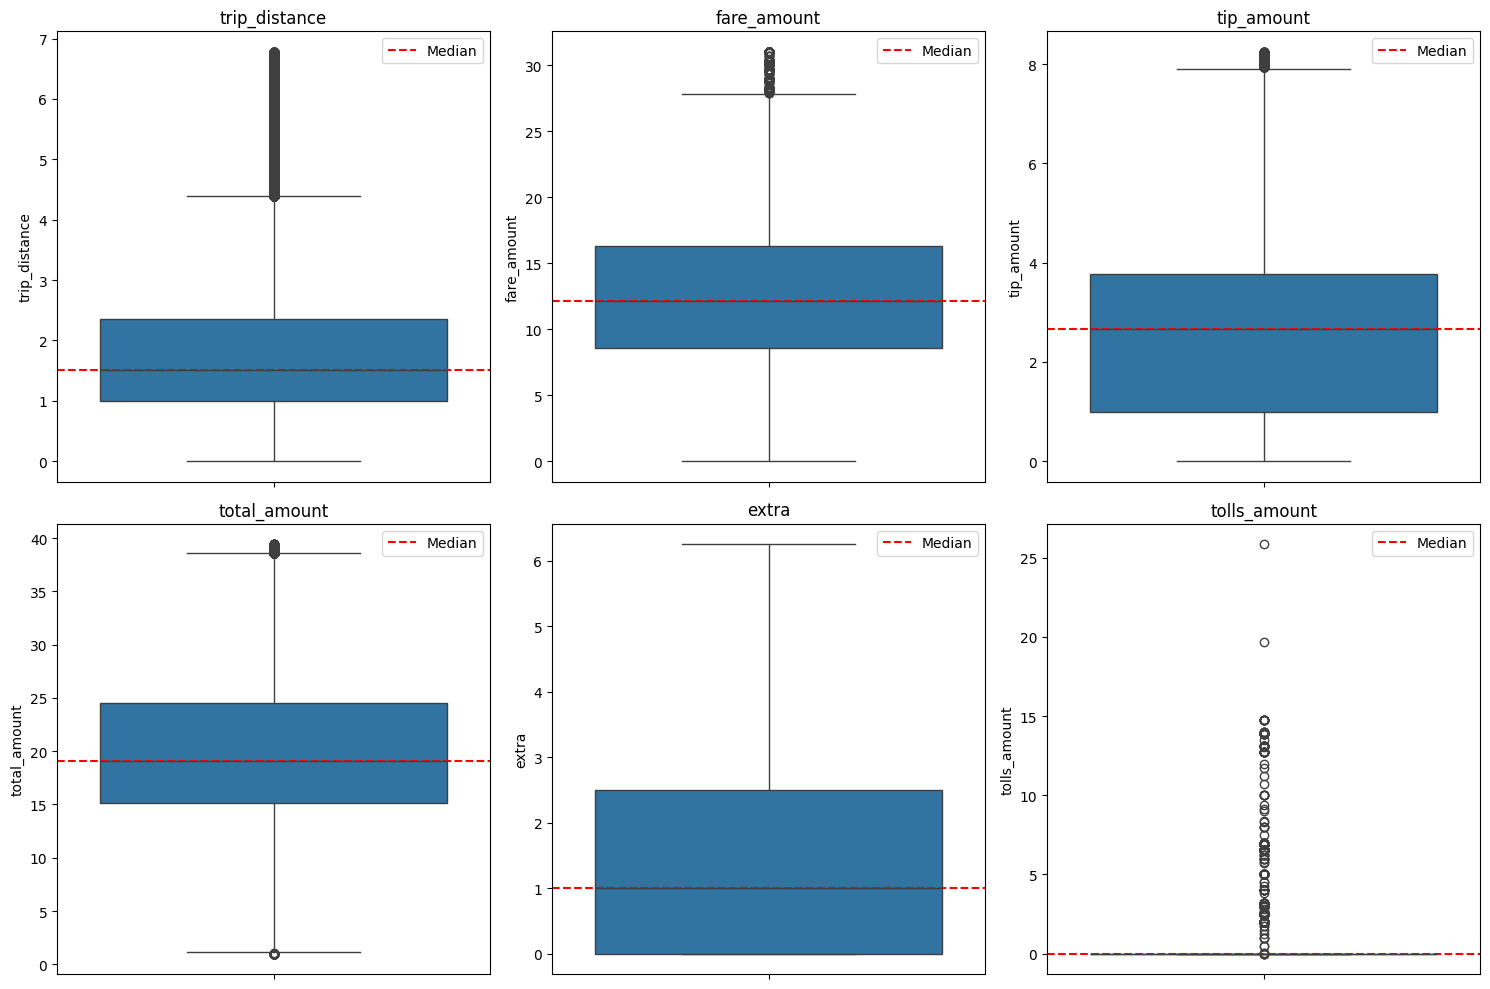

In [28]:
# Re-check the outliers after handling
cols_to_check = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'extra', 'tolls_amount']

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
    median_val = df[col].median()
    plt.axhline(median_val, color='r', linestyle='--', label='Median')
    plt.legend()
plt.tight_layout()

plt.show()

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [29]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'calculated_trip_duration']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

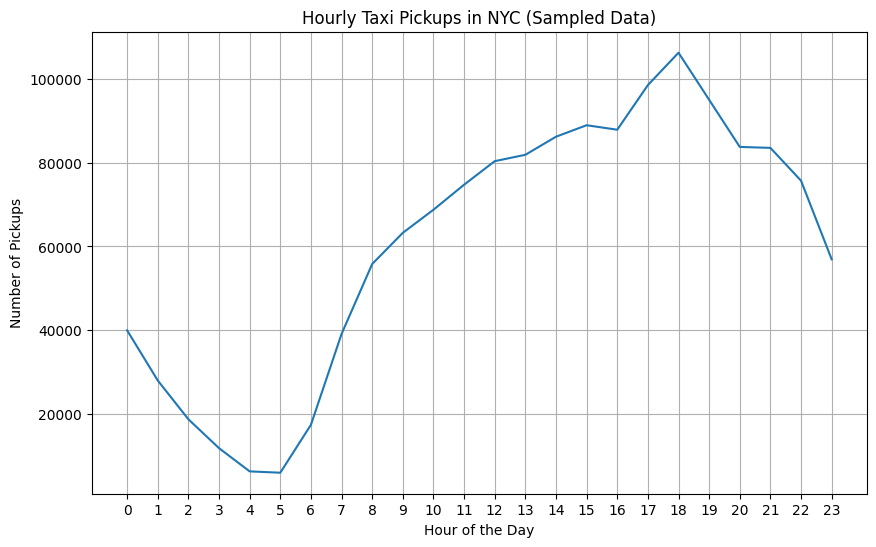

In [30]:
# Find and show the hourly trends in taxi pickups
df['hour'] = df['tpep_pickup_datetime'].dt.hour

hourly_pickups = df.groupby('hour').size()
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_pickups.index, y=hourly_pickups.values)
plt.title('Hourly Taxi Pickups in NYC (Sampled Data)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(0, 24))
plt.grid()
plt.show()



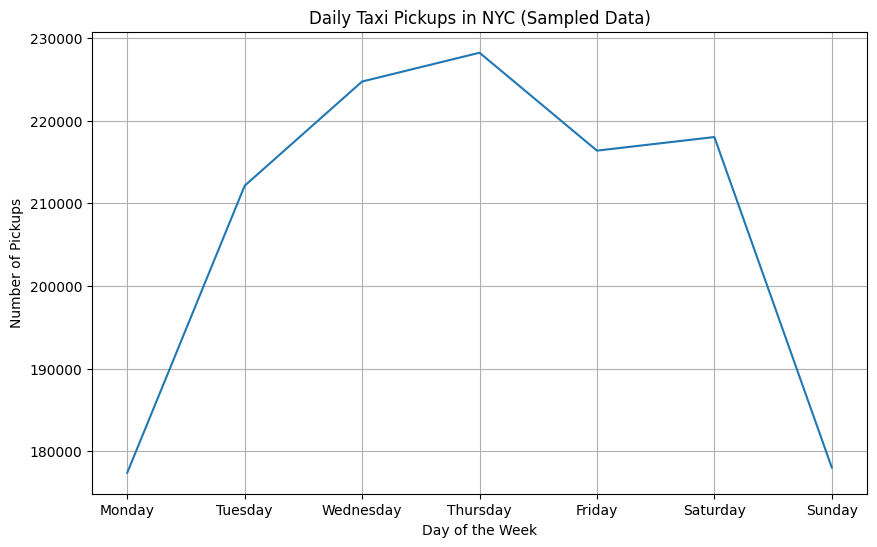

In [31]:
# Find and show the daily trends in taxi pickups (days of the week)
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()
daily_pickups = df.groupby('day_of_week').size()
# Order the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_pickups = daily_pickups.reindex(days_order)   
plt.figure(figsize=(10, 6))
sns.lineplot(x=daily_pickups.index, y=daily_pickups.values)
plt.title('Daily Taxi Pickups in NYC (Sampled Data)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Pickups')
plt.grid()
plt.show()



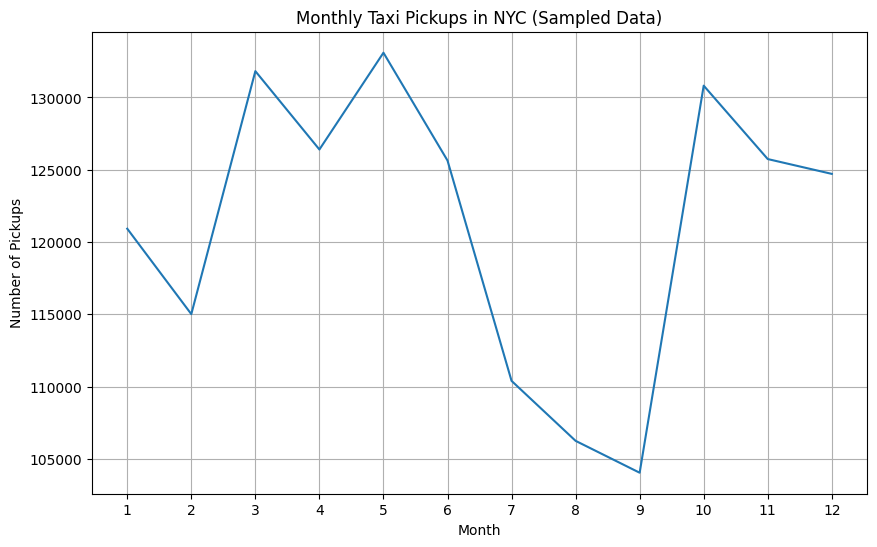

In [32]:
# Show the monthly trends in pickups
df['month'] = df['tpep_pickup_datetime'].dt.month
monthly_pickups = df.groupby('month').size()
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_pickups.index, y=monthly_pickups.values)
plt.title('Monthly Taxi Pickups in NYC (Sampled Data)')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.xticks(range(1, 13))
plt.grid()
plt.show()



##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [33]:
# Analyse the above parameters
financial_columns = ['fare_amount', 'tip_amount', 'total_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge']

# Remove rows where either fare_amount or total_amount is zero
original_count = len(df)
df = df[(df['fare_amount'] > 0) & (df['total_amount'] > 0)]
print(f"Removed {original_count - len(df)} rows with zero fare or total amount")
print(f"Remaining rows: {len(df)}")

for col in financial_columns:
    if (df[col].lt(0)).any():
        print(f"{col}: values >= zero. Count of negative values: {len(df[df[col] < 0])}, total values : {len(df[col])}")
    else:
        print(f"{col}: values are >= zero.") 

# convert the negative values to positive values
for col in financial_columns:
    if (df[col].lt(0)).any():
        df[col] = df[col].abs()
        print(f"Converted negative values in column '{col}' to absolute values.")   




Removed 201 rows with zero fare or total amount
Remaining rows: 1454679
fare_amount: values are >= zero.
tip_amount: values are >= zero.
total_amount: values are >= zero.
extra: values are >= zero.
mta_tax: values are >= zero.
tolls_amount: values are >= zero.
improvement_surcharge: values are >= zero.
congestion_surcharge: values are >= zero.


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

### yes ###

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [34]:
# Create a df with non zero entries for the selected parameters.
cols = ['fare_amount', 'total_amount', 'trip_distance']
for col in cols:
    original_count = len(df)
    df = df[(df[col] > 0)]
    new_count = len(df)
    print(f"Percentage dropped: {((original_count - new_count) / original_count) * 100:.2f}% rows with zero {col}")



Percentage dropped: 0.00% rows with zero fare_amount
Percentage dropped: 0.00% rows with zero total_amount
Percentage dropped: 0.00% rows with zero trip_distance


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

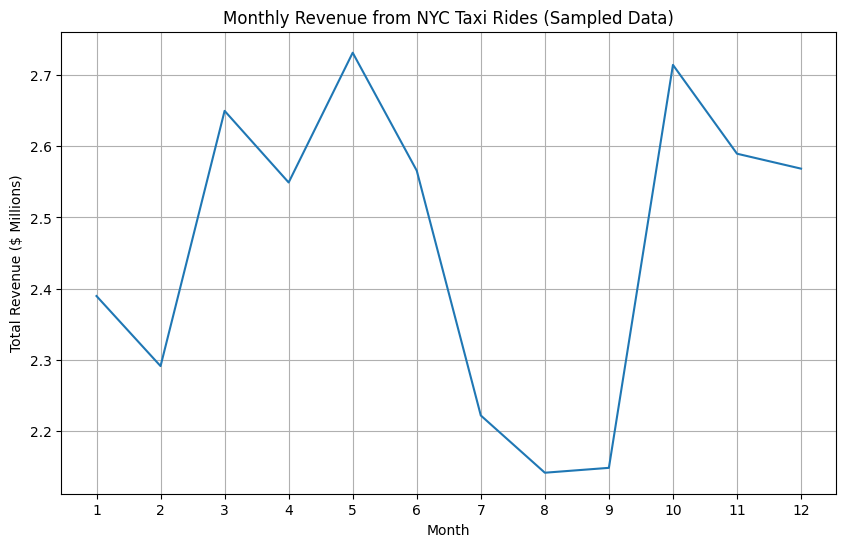

In [35]:
# Group data by month and analyse monthly revenue
# Group data by month and analyse monthly revenue
monthly_revenue = df.groupby('month')['total_amount'].sum()
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values / 1000000)
plt.title('Monthly Revenue from NYC Taxi Rides (Sampled Data)')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($ Millions)')
plt.xticks(range(1, 13))
plt.grid()
plt.show()


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

Quarterly Revenue Proportion (%): {'Q1': 24.79848438317486, 'Q2': 26.541819723298875, 'Q3': 22.029536434993187, 'Q4': 26.630159458533086}


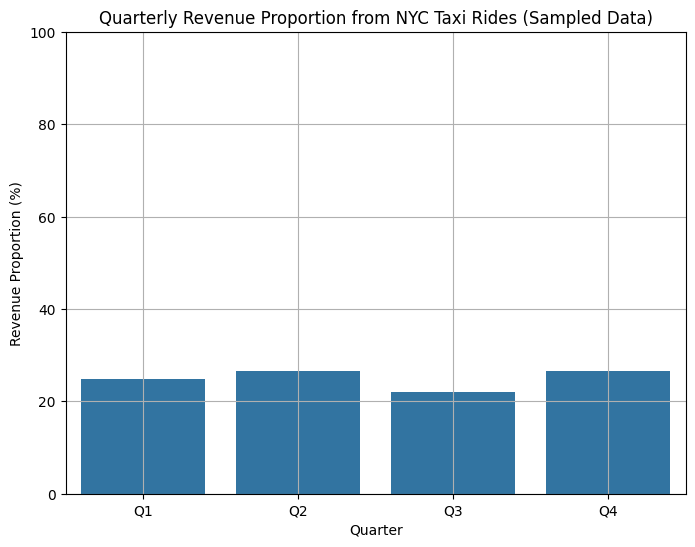

In [36]:
# Calculate proportion of each quarter
quarter = ['Q1', 'Q2', 'Q3', 'Q4']
quarterly_revenue = pd.Series(dtype='float64', index=quarter)
quarterly_revenue['Q1'] = monthly_revenue.loc[1:3].sum()
quarterly_revenue['Q2'] = monthly_revenue.loc[4:6].sum()
quarterly_revenue['Q3'] = monthly_revenue.loc[7:9].sum()
quarterly_revenue['Q4'] = monthly_revenue.loc[10:12].sum()

total_revenue = quarterly_revenue.sum()
quarterly_proportion = (quarterly_revenue / total_revenue) * 100
print("Quarterly Revenue Proportion (%):", quarterly_proportion.to_dict())

plt.figure(figsize=(8, 6))
sns.barplot(x=quarterly_proportion.index, y=quarterly_proportion.values)
plt.title('Quarterly Revenue Proportion from NYC Taxi Rides (Sampled Data)')
plt.xlabel('Quarter')
plt.ylabel('Revenue Proportion (%)')
plt.ylim(0, 100)
plt.grid()
plt.show()



**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

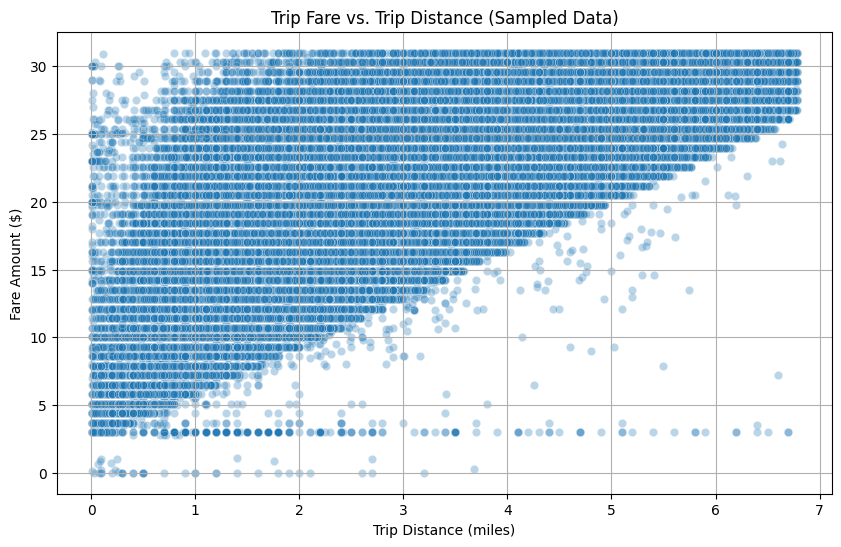

Correlation between trip distance and fare amount: 0.87


In [37]:
df_filtered = df[df['fare_amount'] > 0]

# Show how trip fare is affected by distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df_filtered, alpha=0.3)
plt.title('Trip Fare vs. Trip Distance (Sampled Data)')
plt.xlabel('Trip Distance (miles)') 
plt.ylabel('Fare Amount ($)')
plt.grid()
plt.show()

correlation = df_filtered['trip_distance'].corr(df_filtered['fare_amount'])
print(f"Correlation between trip distance and fare amount: {correlation:.2f}")



**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [38]:
df.columns.tolist()
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60  # in minutes
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'calculated_trip_duration',
 'hour',
 'day_of_week',
 'month',
 'trip_duration']

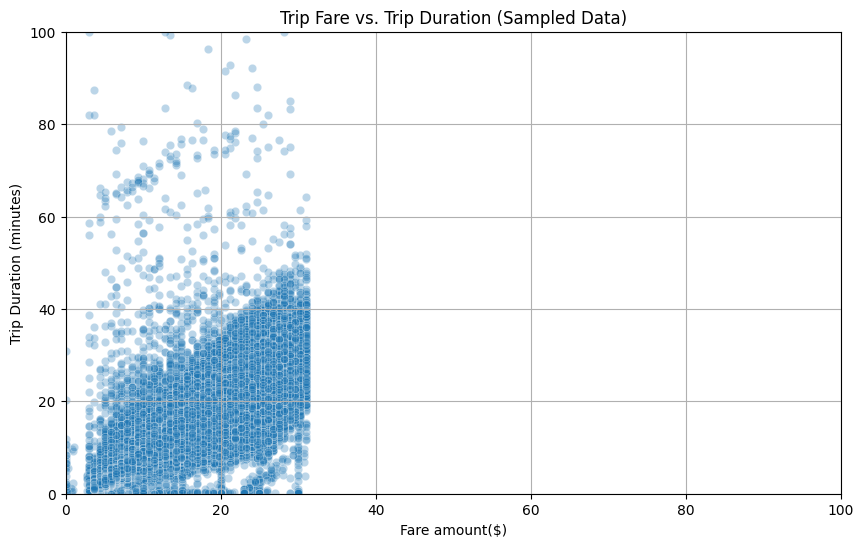

In [39]:
# Show relationship between fare and trip duration
df.columns.tolist()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='trip_duration', data=df, alpha=0.3)
plt.title('Trip Fare vs. Trip Duration (Sampled Data)')
plt.xlabel('Fare amount($)') 
plt.ylabel('Trip Duration (minutes)')
plt.xlim(0, 100)  # Focus on fares up to $100
plt.ylim(0, 100)   # Focus on trips up to 100 minutes
plt.grid()
plt.show()


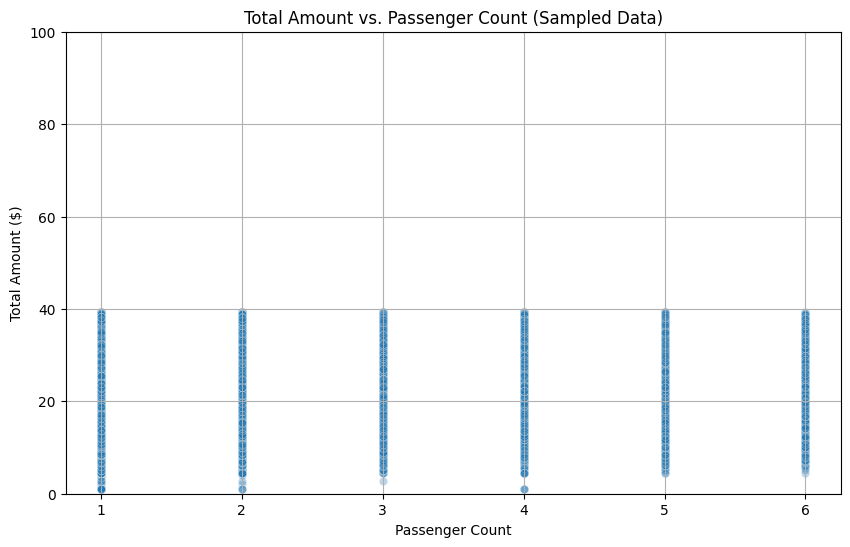

In [40]:
# Show relationship between fare and number of passengers
df.columns.tolist()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='passenger_count', y='total_amount', data=df, alpha=0.3)
plt.title('Total Amount vs. Passenger Count (Sampled Data)')
plt.xlabel('Passenger Count') 
plt.ylabel('Total Amount ($)')
plt.ylim(0, 100)  # Focus on total amounts up to $100


plt.grid()
plt.show()


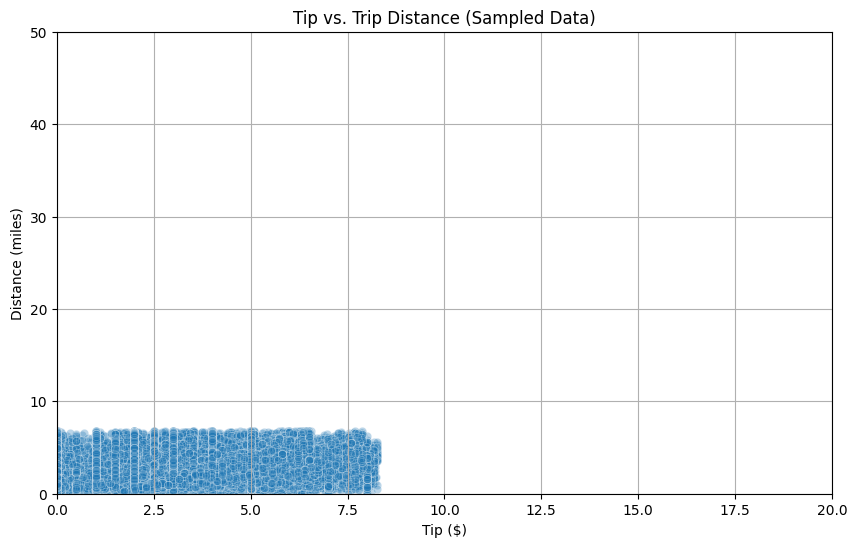

In [41]:
# Show relationship between tip and trip distance

# Show relationship between fare and trip duration
df.columns.tolist()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tip_amount', y='trip_distance', data=df, alpha=0.3)
plt.title('Tip vs. Trip Distance (Sampled Data)')
plt.xlabel('Tip ($)') 
plt.ylabel('Distance (miles)')
plt.xlim(0, 20)  # Focus on tips up to $20
plt.ylim(0, 50)   # Focus on trips up to 50 miles
plt.grid()
plt.show()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

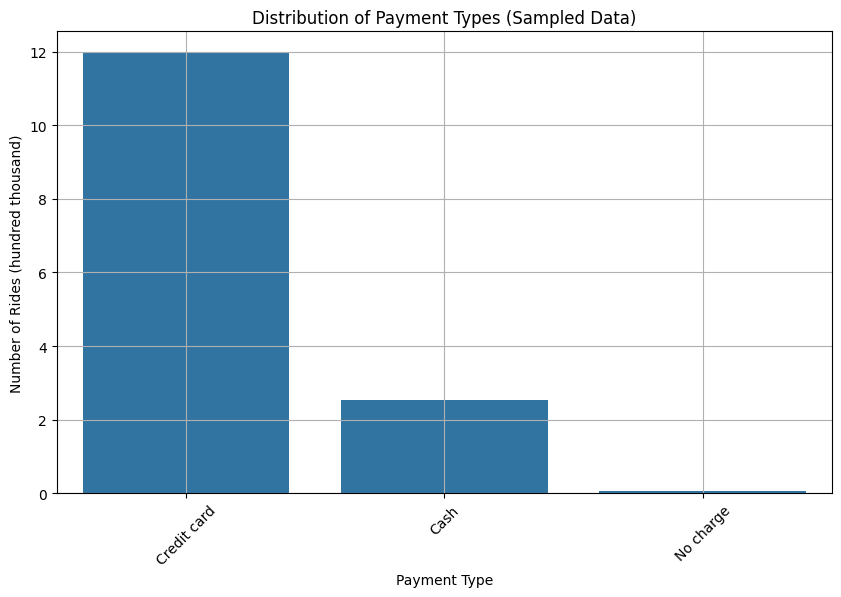

In [42]:
# Analyse the distribution of different payment types (payment_type).
payment_counts = df['payment_type'].value_counts().sort_index()
payment_labels = [Payment_type.get(i) for i in payment_counts.index]    
plt.figure(figsize=(10, 6))
sns.barplot(x=payment_labels, y=payment_counts.values/100000)
plt.title('Distribution of Payment Types (Sampled Data)')
plt.xlabel('Payment Type')
plt.ylabel('Number of Rides (hundred thousand)')
plt.xticks(rotation=45)

plt.grid()
plt.show()




- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [43]:
! pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [44]:
import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file('/home/sirkumar/IIITB/EDA/data_NYC_Taxi/taxi_zones/taxi_zones.shp')
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


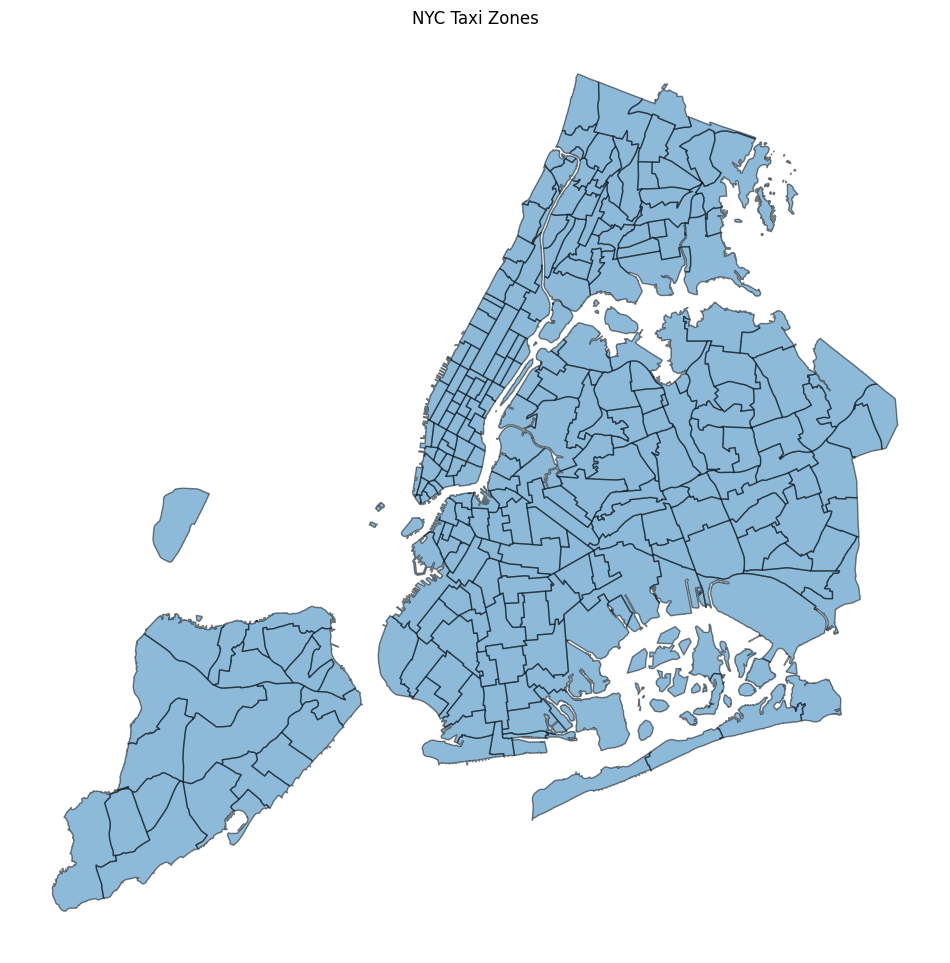

In [45]:
print(zones.info())
# Plot the zones map
zones.plot(figsize=(12, 12), alpha=0.5, edgecolor='k')
plt.title('NYC Taxi Zones')
plt.axis('off')
plt.show()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [46]:
# Merge zones and trip records using locationID and PULocationID

merged_df = df.merge(zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')
print("After merging, merged_df has shape:", merged_df.shape)
print(merged_df.columns.tolist())
merged_df.head()


After merging, merged_df has shape: (1454694, 26)
['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'calculated_trip_duration', 'hour', 'day_of_week', 'month', 'trip_duration', 'LocationID', 'zone']


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,Airport_fee,calculated_trip_duration,hour,day_of_week,month,trip_duration,LocationID,zone
0,2,2023-07-01 00:51:04,2023-07-01 00:56:50,1.0,1.42,1.0,N,107,162,1,...,16.32,2.5,0.0,5.766667,0,Saturday,7,5.766667,107.0,Gramercy
1,2,2023-07-01 00:37:46,2023-07-01 00:45:30,3.0,1.10,1.0,N,249,79,1,...,17.16,2.5,0.0,7.733333,0,Saturday,7,7.733333,249.0,West Village
2,2,2023-07-01 00:00:34,2023-07-01 00:16:34,1.0,3.20,1.0,N,142,41,1,...,28.08,2.5,0.0,16.000000,0,Saturday,7,16.000000,142.0,Lincoln Square East
3,2,2023-07-01 00:49:46,2023-07-01 01:00:16,2.0,1.55,1.0,N,100,137,1,...,19.68,2.5,0.0,10.500000,0,Saturday,7,10.500000,100.0,Garment District
4,2,2023-07-01 00:01:51,2023-07-01 00:07:48,1.0,0.79,1.0,N,114,79,1,...,15.48,2.5,0.0,5.950000,0,Saturday,7,5.950000,114.0,Greenwich Village South


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [47]:
# Group data by location and calculate the number of trips

trip_counts = df.groupby('PULocationID').size().reset_index(name='number of trips')
trip_counts.head()


,PULocationID,number of trips
0,1,12
1,4,1606
2,6,19
3,7,559
4,9,4


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [48]:
# Merge trip counts back to the zones GeoDataFrame
zones_with_trips = pd.merge(zones, trip_counts, left_on='LocationID', right_on='PULocationID', how='left')
zones_with_trips.head()






,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,number of trips
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,12.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",NaN,NaN
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,1606.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",NaN,NaN


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

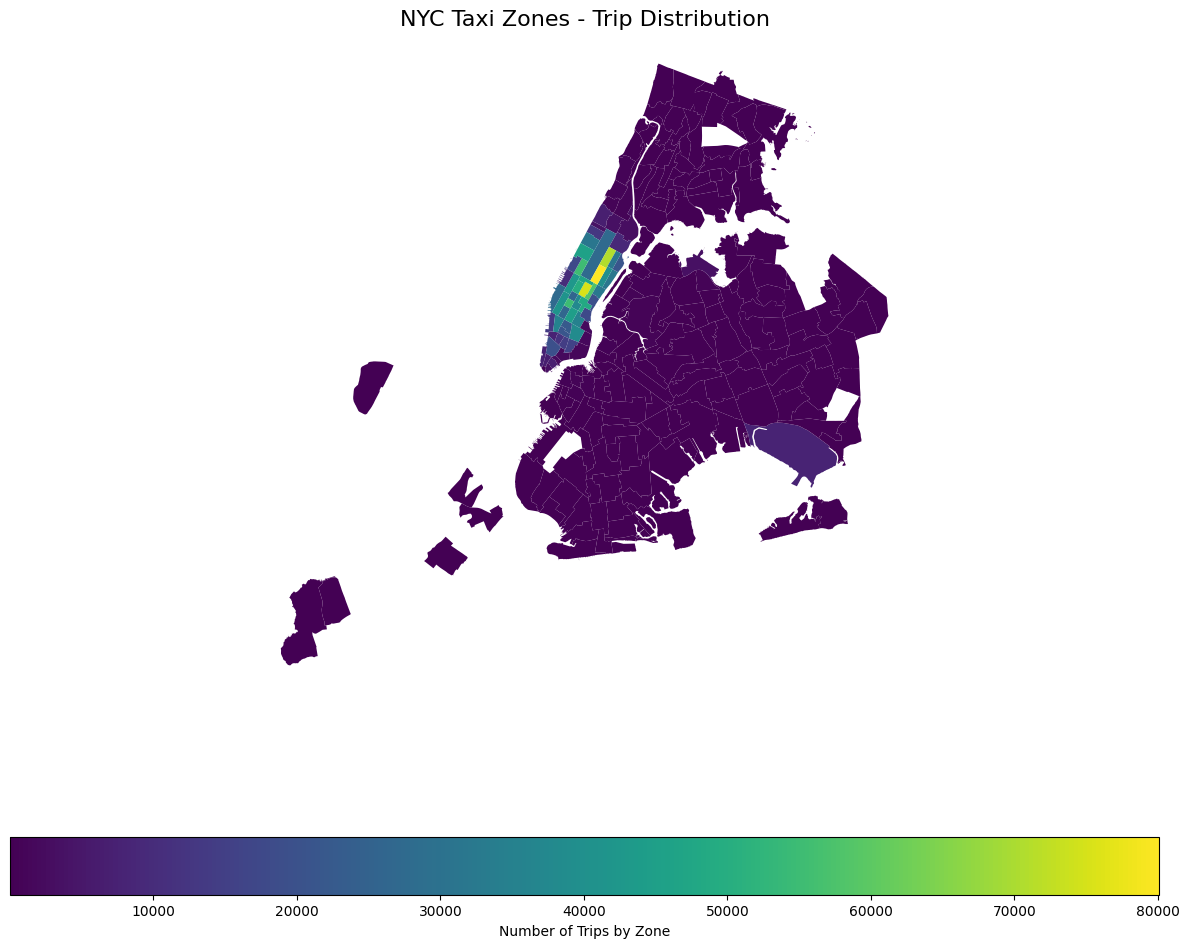

In [49]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}

# Plot the map and display zone wise trips
zones_with_trips.plot(
    column='number of trips', 
    ax=ax, 
    legend=True,
    legend_kwds={'label': "Number of Trips by Zone",'orientation': "horizontal"},
)
plt.title('NYC Taxi Zones - Trip Distribution', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [50]:
# can you try displaying the zones DF sorted by the number of trips?
zones_with_trips_sorted = zones_with_trips.sort_values(by='number of trips', ascending=False)
print(zones_with_trips_sorted[['zone', 'number of trips']].head(20))



                              zone  number of trips
236          Upper East Side South          80096.0
160                 Midtown Center          75200.0
235          Upper East Side North          70720.0
161                   Midtown East          58004.0
141            Lincoln Square East          55302.0
185   Penn Station/Madison Sq West          55002.0
229      Times Sq/Theatre District          50014.0
169                    Murray Hill          48251.0
162                  Midtown North          46898.0
238          Upper West Side South          45689.0
233                       Union Sq          44719.0
47                    Clinton East          42580.0
67                    East Chelsea          41343.0
140                Lenox Hill West          39669.0
78                    East Village          38402.0
163                  Midtown South          37516.0
248                   West Village          35977.0
106                       Gramercy          34843.0
228  Sutton 

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [51]:
# Find routes which have the slowest speeds at different times of the day
print(df.columns.to_list())
# Check for negative values


df_route = df[['PULocationID', 'DOLocationID', 'trip_distance', 'trip_duration', 'tpep_pickup_datetime']].copy() #Make an independent copy otherwise was getting an error
df_route['speed_mph'] = (df_route['trip_distance'] / (df_route['trip_duration'] / 60)) #add a column for speed in mph
df_route['hour'] = df_route['tpep_pickup_datetime'].dt.hour # add another column for hour
print(df_route.tail())
# Group by route and hour to calculate average speed
# All trips from Zone 161 → Zone 237 at 9 AM
# All trips from Zone 161 → Zone 237 at 10 AM
# All trips from Zone 48 → Zone 142 at 9 AM
# from each group get the speed_mph and take a mean of that
average_speeds = df_route.groupby(['PULocationID', 'DOLocationID', 'hour'])['speed_mph'].mean()
average_speeds = average_speeds.reset_index()
print(average_speeds.sort_values(by='speed_mph').head(20))  # Show the slowest routes




['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'calculated_trip_duration', 'hour', 'day_of_week', 'month', 'trip_duration']
         PULocationID  DOLocationID  trip_distance  trip_duration  \
1896393            41           226           1.78      17.233333   
1896394            79           170           2.03      13.150000   
1896395           170           143           2.63      12.750000   
1896398            87           231           1.00      10.350000   
1896399           209           225           5.04      23.466667   

        tpep_pickup_datetime  speed_mph  hour  
1896393  2023-06-30 23:11:55   6.197292    23  
1896394  2023-06-30 23:19:44   9.262357    23  
1896395  2023-06-30 23:53:10  12.3764

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

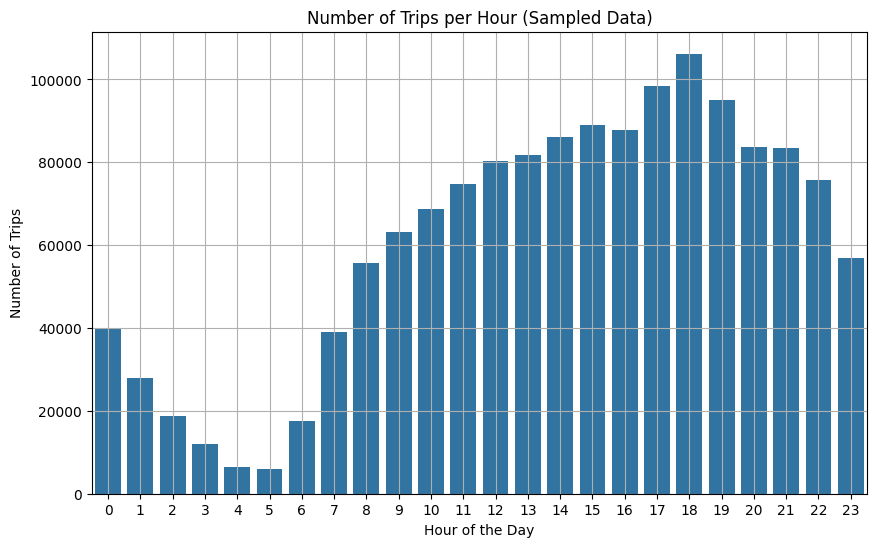

In [52]:
# Visualise the number of trips per hour and find the busiest hour
hourly_trip_counts = df.groupby('hour').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_trip_counts.index, y=hourly_trip_counts.values)
plt.title('Number of Trips per Hour (Sampled Data)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid()
plt.show()




Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

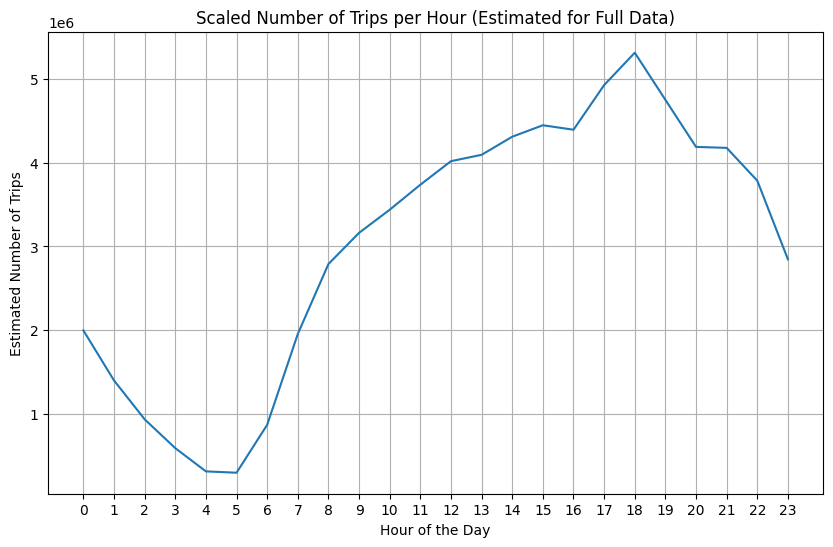

In [53]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.1  # 5% sampling
scaling_factor = 5 / sample_fraction
scaled_hourly_trip_counts = hourly_trip_counts * scaling_factor
plt.figure(figsize=(10, 6))
sns.lineplot(x=scaled_hourly_trip_counts.index, y=scaled_hourly_trip_counts.values)
plt.title('Scaled Number of Trips per Hour (Estimated for Full Data)')
plt.xlabel('Hour of the Day')
plt.ylabel('Estimated Number of Trips')
plt.xticks(range(0, 24))
plt.grid()
plt.show()



**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

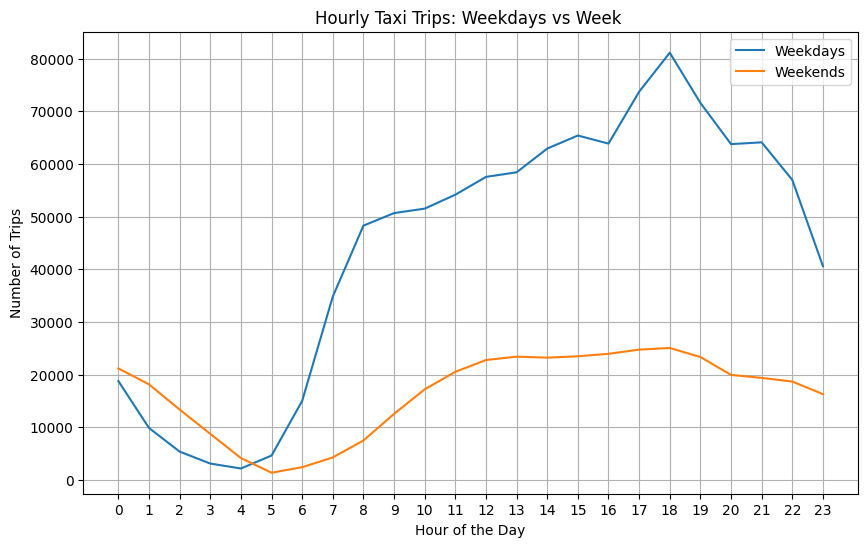

In [54]:
# Compare traffic trends for the week days and weekends
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])
hourly_trips_weekday = df[~df['is_weekend']].groupby('hour').size()
hourly_trips_weekend = df[df['is_weekend']].groupby('hour').size()
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_trips_weekday.index, y=hourly_trips_weekday.values, label='Weekdays')
sns.lineplot(x=hourly_trips_weekend.index, y=hourly_trips_weekend.values, label='Weekends')
plt.title('Hourly Taxi Trips: Weekdays vs Week ')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid()
plt.legend()
plt.show()



What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [55]:
# Find top 10 pickup and dropoff zones
top_pickup_zones = df['PULocationID'].value_counts().head(10).reset_index()
top_pickup_zones.columns = ['LocationID', 'pickup_count']

top_dropoff_zones = df['DOLocationID'].value_counts().head(10).reset_index()
top_dropoff_zones.columns = ['LocationID', 'dropoff_count']

# Merge with zone names
top_pickup_zones = top_pickup_zones.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
top_dropoff_zones = top_dropoff_zones.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

print("Top 10 Pickup Zones:\n", top_pickup_zones[['zone', 'pickup_count']])
print("\nTop 10 Dropoff Zones:\n", top_dropoff_zones[['zone', 'dropoff_count']])


                                                           



Top 10 Pickup Zones:
                            zone  pickup_count
0         Upper East Side South         80096
1                Midtown Center         75200
2         Upper East Side North         70720
3                  Midtown East         58004
4           Lincoln Square East         55302
5  Penn Station/Madison Sq West         55002
6     Times Sq/Theatre District         50014
7                   Murray Hill         48251
8                 Midtown North         46898
9         Upper West Side South         45689

Top 10 Dropoff Zones:
                         zone  dropoff_count
0      Upper East Side North          73808
1      Upper East Side South          71586
2             Midtown Center          62685
3                Murray Hill          48029
4        Lincoln Square East          46579
5               Midtown East          45589
6      Upper West Side South          45120
7            Lenox Hill West          43842
8  Times Sq/Theatre District          43528
9       

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [56]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

bottom_pickup_zones = df['PULocationID'].value_counts().tail(10).reset_index()
bottom_pickup_zones.columns = ['LocationID', 'pickup_count']

bottom_dropoff_zones = df['DOLocationID'].value_counts().tail(10).reset_index()
bottom_dropoff_zones.columns = ['LocationID', 'dropoff_count']

# Merge with zone names
bottom_pickup_zones = bottom_pickup_zones.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
bottom_dropoff_zones = bottom_dropoff_zones.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

print("Bottom 10 Pickup Zones:\n", bottom_pickup_zones[['zone', 'pickup_count']])
print("\nBottom 10 Dropoff Zones:\n", bottom_dropoff_zones[['zone', 'dropoff_count']])

#Get the ratio of pickups and dropoffs for each zone
zone_pickup_counts_df = df.groupby('PULocationID').size().reset_index(name='count')
zone_dropoff_counts_df = df.groupby('DOLocationID').size().reset_index(name='count')

#Prepare the ground of merge. Rename PU and DO LocationID as LocationID so that they can be merged
zone_pickup_counts_df = zone_pickup_counts_df.rename(columns={'PULocationID': 'LocationID', 'count': 'pickup_count'})
zone_dropoff_counts_df = zone_dropoff_counts_df.rename(columns={'DOLocationID': 'LocationID', 'count': 'dropoff_count'})
zone_counts_df = pd.merge(zone_pickup_counts_df, zone_dropoff_counts_df, on='LocationID', how='outer').fillna(0)
print(zone_counts_df.head())

#add ratio column for pickups to dropoffs
zone_counts_df['pickup_dropoff_ratio'] = zone_counts_df['pickup_count'] / zone_counts_df['dropoff_count']
print(zone_counts_df.head())

#Now add a column so that we can get the zone names
zone_counts_df = zone_counts_df.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
zone_counts_df = zone_counts_df.sort_values(by='pickup_dropoff_ratio', ascending=False)
print("Top 10 Zones by Pickup/Dropoff Ratio:\n", zone_counts_df[['zone', 'pickup_dropoff_ratio']].head(10))




Bottom 10 Pickup Zones:
               zone  pickup_count
0      Eastchester             1
1       Douglaston             1
2           Hollis             1
3     Country Club             1
4              NaN             1
5  Hammels/Arverne             1
6     Crotona Park             1
7   Sheepshead Bay             1
8     Far Rockaway             1
9        Gravesend             1

Bottom 10 Dropoff Zones:
                        zone  dropoff_count
0                 Stapleton              1
1  South Beach/Dongan Hills              1
2             Port Richmond              1
3    Charleston/Tottenville              1
4        Van Cortlandt Park              1
5         Rossville/Woodrow              1
6               Great Kills              1
7               Westerleigh              1
8                Pelham Bay              1
9              Crotona Park              1
   LocationID  pickup_count  dropoff_count
0           1          12.0           15.0
1           4        1606.

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [57]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
top_pickup_zones_df = df[(df['hour'] >= 23) | (df['hour'] <= 5)]['PULocationID'].value_counts().sort_values(ascending=False).head(10).reset_index(name='pickup_count')
top_dropoff_zones_df = df[(df['hour'] >= 23) | (df['hour'] <= 5)]['DOLocationID'].value_counts().sort_values(ascending=False).head(10).reset_index(name='dropoff_count')

#Prepare the ground of merge. Rename PU and DO LocationID as LocationID so that they can be merged
top_pickup_zones_df = top_pickup_zones_df.rename(columns={'PULocationID': 'LocationID'})
top_dropoff_zones_df = top_dropoff_zones_df.rename(columns={'DOLocationID': 'LocationID'})
zone_counts_df = pd.merge(top_pickup_zones_df, top_dropoff_zones_df, on='LocationID', how='outer')
#Now add a column so that we can get the zone names
top_zone_counts_df = zone_counts_df.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

print("Top 10 Pickup Zones during Night Hours:\n", top_zone_counts_df[['zone', 'pickup_count']].sort_values(by='pickup_count', ascending=False))
print("\nTop 10 Dropoff Zones during Night Hours:\n", top_zone_counts_df[['zone', 'dropoff_count']].sort_values(by='dropoff_count', ascending=False))


Top 10 Pickup Zones during Night Hours:
                              zone  pickup_count
2                    East Village       13847.0
13                   West Village       10924.0
0                    Clinton East        8831.0
7                 Lower East Side        8400.0
5         Greenwich Village South        7768.0
12      Times Sq/Theatre District        6578.0
10   Penn Station/Madison Sq West        5864.0
8                   Midtown South        5321.0
4                        Gramercy        5064.0
1                    East Chelsea        5063.0
3                        Flatiron           NaN
6                 Lenox Hill West           NaN
9                     Murray Hill           NaN
11  Sutton Place/Turtle Bay North           NaN
14                 Yorkville West           NaN

Top 10 Dropoff Zones during Night Hours:
                              zone  dropoff_count
2                    East Village         7682.0
0                    Clinton East         6166.0
9

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [58]:
# Filter for night hours (11 PM to 5 AM). Find the revenue
night_hours_df = df[(df['hour'] >= 23) | (df['hour'] <= 5)]
night_revenue = night_hours_df['total_amount'].sum()
print(f"Total Revenue during Night Hours (11 PM to 5 AM): ${night_revenue:,.2f}")

day_hours_df = df[(df['hour'] > 5) & (df['hour'] < 23)]
day_revenue = day_hours_df['total_amount'].sum()
print(f"Total Revenue during Day Hours (6 AM to 10 PM): ${day_revenue:,.2f}")




Total Revenue during Night Hours (11 PM to 5 AM): $3,460,183.63
Total Revenue during Day Hours (6 AM to 10 PM): $26,101,145.63


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

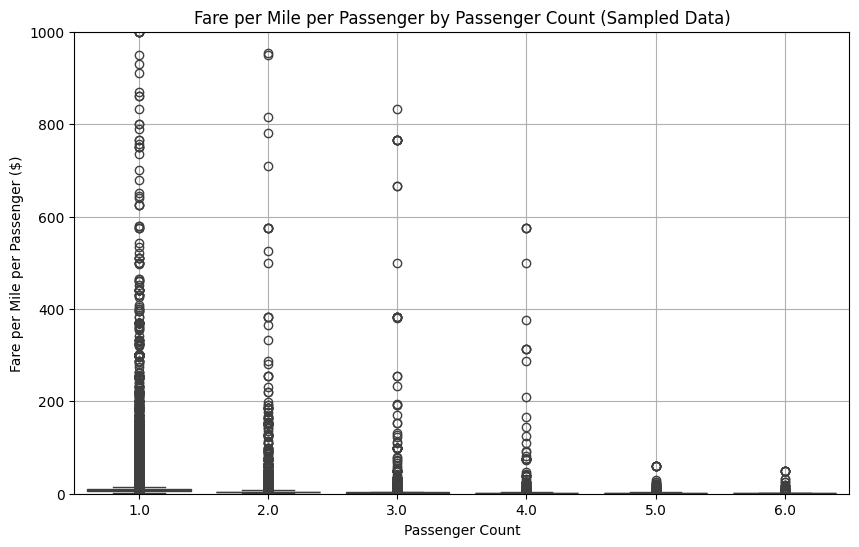

In [59]:
# Analyse the fare per mile per passenger for different passenger counts
df['fare_per_mile_per_passenger'] = df['fare_amount'] / (df['trip_distance'] * df['passenger_count'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='fare_per_mile_per_passenger', data=df)
plt.title('Fare per Mile per Passenger by Passenger Count (Sampled Data)')
plt.xlabel('Passenger Count')
plt.ylabel('Fare per Mile per Passenger ($)')
plt.ylim(0, 1000)  # Focus on reasonable fare values
plt.grid()
plt.show()




**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

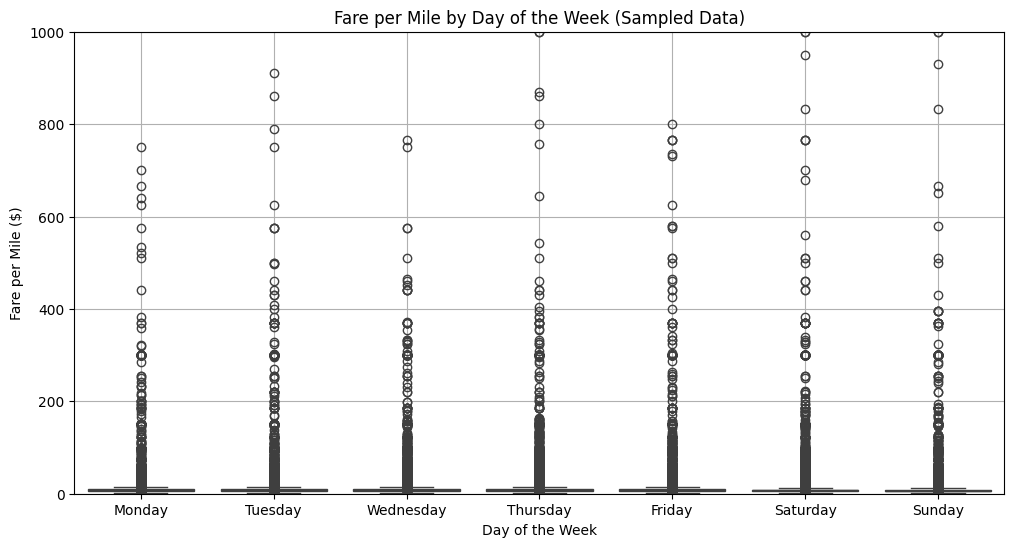

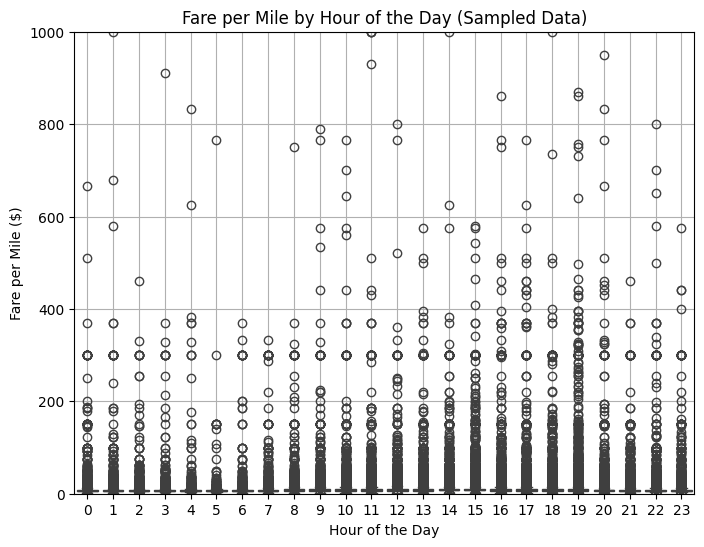

In [60]:
# Compare the average fare per mile for different days and for different times of the day
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='fare_per_mile', data=df, order=days_order)
plt.title('Fare per Mile by Day of the Week (Sampled Data)')
plt.xlabel('Day of the Week')   
plt.ylabel('Fare per Mile ($)')
plt.ylim(0, 1000)  # Focus on reasonable fare values    
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='hour', y='fare_per_mile', data=df)
plt.title('Fare per Mile by Hour of the Day (Sampled Data)')
plt.xlabel('Hour of the Day')
plt.ylabel('Fare per Mile ($)')
plt.ylim(0, 1000)  # Focus on reasonable fare values
plt.grid()
plt.show()




**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

   VendorID  fare_per_mile
0         1       8.457430
1         2       8.883757


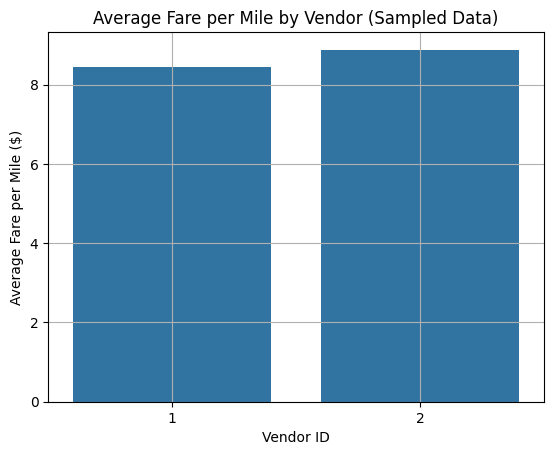

In [61]:
# Compare fare per mile for different vendors
df_vendor = df[df['trip_distance'] > 0].copy()
df_vendor['fare_per_mile'] = df_vendor['fare_amount'] / df_vendor['trip_distance']
vendor_fare_comparison_df = df_vendor.groupby('VendorID')['fare_per_mile'].mean().reset_index()
print(vendor_fare_comparison_df.head())

#Draw it
sns.barplot(x='VendorID', y='fare_per_mile', data=vendor_fare_comparison_df)
plt.title('Average Fare per Mile by Vendor (Sampled Data)')
plt.xlabel('Vendor ID')
plt.ylabel('Average Fare per Mile ($)')
plt.grid()
plt.show()


**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


   VendorID       distance_tier  fare_per_mile
0         1   Long (5-10 miles)       4.702942
1         1  Medium (2-5 miles)       6.339020
2         1    Short (<2 miles)       9.607189
3         2   Long (5-10 miles)       4.738347
4         2  Medium (2-5 miles)       6.429558
5         2    Short (<2 miles)      10.213962


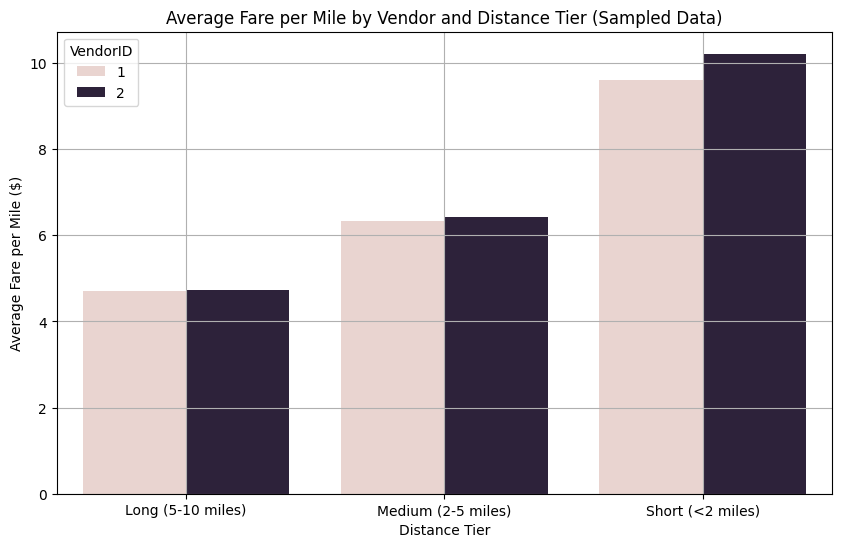

In [62]:
# Defining distance tiers
def distance_tier(distance):
    if distance < 2:
        return 'Short (<2 miles)'
    elif 2 <= distance < 5:
        return 'Medium (2-5 miles)'
    elif 5 <= distance < 10:
        return 'Long (5-10 miles)'
    else:
        return 'Very Long (10+ miles)'

#add a new column for distance tier
df['distance_tier'] = df['trip_distance'].apply(distance_tier)


#compare the fare rates of the different vendors
vendor_fare_comparison_df = df.groupby(['VendorID', 'distance_tier'])['fare_per_mile'].mean().reset_index()
print(vendor_fare_comparison_df)
# Draw it
plt.figure(figsize=(10, 6))
sns.barplot(x='distance_tier', y='fare_per_mile', hue='VendorID', data=vendor_fare_comparison_df)
plt.title('Average Fare per Mile by Vendor and Distance Tier (Sampled Data)')
plt.xlabel('Distance Tier')
plt.ylabel('Average Fare per Mile ($)')
plt.grid()
plt.show()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [63]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

#add tip_percentage column
df['tip_percentage'] = (df['tip_amount'] / df['fare_amount']) * 100

#average tip percentage by distance tier
tip_by_distance_df = df.groupby('distance_tier')['tip_percentage'].mean().reset_index().sort_values(by='tip_percentage', ascending=True)
print(tip_by_distance_df)

#average tip percentage by passenger count
tip_by_passenger_df = df.groupby('passenger_count')['tip_percentage'].mean().reset_index().sort_values(by='tip_percentage', ascending=True)
print(tip_by_passenger_df)

#average tip percentage by hour
tip_by_hour_df = df.groupby('hour')['tip_percentage'].mean().reset_index().sort_values(by='tip_percentage', ascending=True)
print(tip_by_hour_df)

print("Long distance lead to low tip percentages")

        distance_tier  tip_percentage
0   Long (5-10 miles)       12.629681
1  Medium (2-5 miles)       18.655729
2    Short (<2 miles)       22.444072
   passenger_count  tip_percentage
3              4.0       18.168955
2              3.0       19.669642
1              2.0       20.475608
5              6.0       20.836996
4              5.0       20.849949
0              1.0       21.265206
    hour  tip_percentage
4      4       18.806792
5      5       19.073190
13    13       19.433648
14    14       19.460921
15    15       19.474760
6      6       19.486578
12    12       19.526663
11    11       19.550438
10    10       19.735377
9      9       20.282981
7      7       20.406497
3      3       20.572763
8      8       20.649544
2      2       21.194307
0      0       21.213739
1      1       21.319015
23    23       21.436058
16    16       21.579836
22    22       21.966209
20    20       22.133836
21    21       22.136632
17    17       22.382463
18    18       22.894342
19 

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [64]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

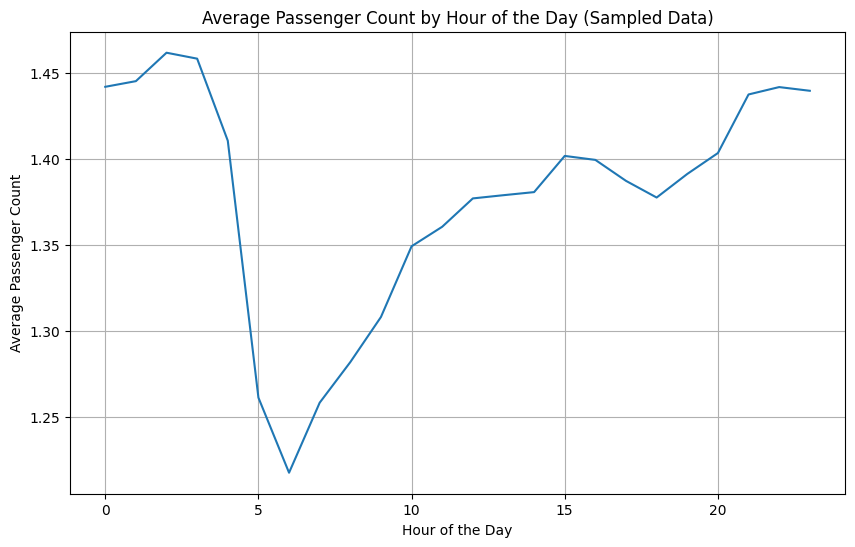

In [65]:
# See how passenger count varies across hours and days
passenger_counts_by_hour = df.groupby('hour')['passenger_count'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='passenger_count', data=passenger_counts_by_hour)
plt.title('Average Passenger Count by Hour of the Day (Sampled Data)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Passenger Count')
plt.grid()
plt.show()
             




**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

Top 10 Zones by Average Passenger Count:
                         zone  passenger_count
155      Ocean Parkway South         6.000000
111          Jamaica Estates         3.500000
227       Woodlawn/Wakefield         3.000000
128                  Madison         3.000000
160               Pelham Bay         2.500000
168          Queensboro Hill         2.500000
24               Brownsville         2.333333
13                   Belmont         2.333333
80                  Flushing         2.076923
2    Arrochar/Fort Wadsworth         2.000000


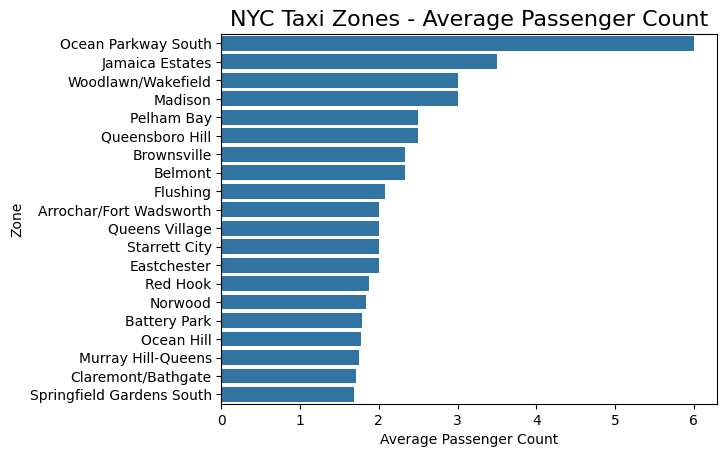

In [66]:
# How does passenger count vary across zones
passenger_counts_by_zone = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
passenger_counts_by_zone = passenger_counts_by_zone.merge(zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')
passenger_counts_by_zone = passenger_counts_by_zone.sort_values(by='passenger_count', ascending=False)
print("Top 10 Zones by Average Passenger Count:\n", passenger_counts_by_zone[['zone', 'passenger_count']].head(10))


# Plot the map and display zone wise average passenger counts
sns.barplot(x='passenger_count', y='zone', data=passenger_counts_by_zone.head(20))
plt.title('NYC Taxi Zones - Average Passenger Count', fontsize=16)
plt.xlabel('Average Passenger Count')
plt.ylabel('Zone')
plt.show()



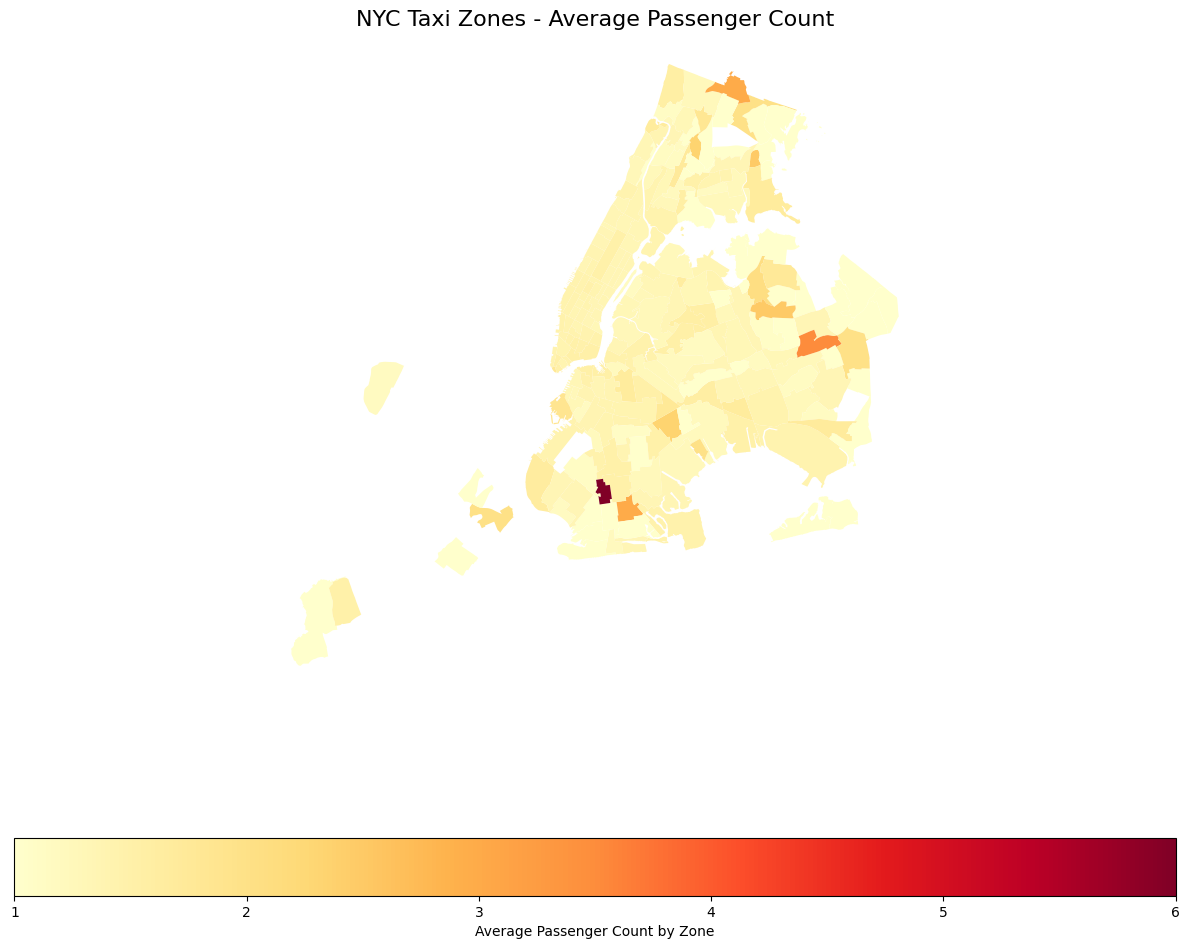

In [67]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

passenger_avg_by_zone = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
passenger_avg_by_zone.columns = ['LocationID', 'avg_passenger_count']

zones_with_passenger_counts = zones.merge(passenger_avg_by_zone, on='LocationID', how='left')

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

zones_with_passenger_counts.plot(
    column='avg_passenger_count',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    legend_kwds={'label': "Average Passenger Count by Zone", 'orientation': "horizontal"},
)
plt.title('NYC Taxi Zones - Average Passenger Count', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

Frequency of Surcharge Application (%):
extra                    61.164216
mta_tax                  99.921907
tolls_amount              0.141406
improvement_surcharge    99.999106
congestion_surcharge     97.022298
dtype: float64


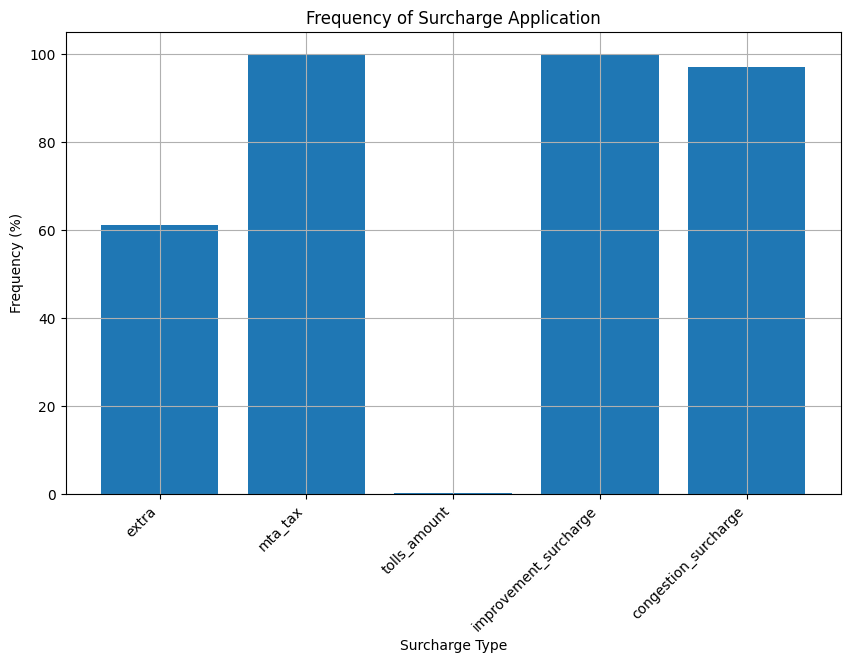

In [68]:
# How often is each surcharge applied?
surcharge_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge']
surcharge_application = {}
# zones where surcharge are applied more frequently
surcharge_frequency = df[surcharge_cols].astype(bool).sum() / len(df) * 100

print("Frequency of Surcharge Application (%):")
print(surcharge_frequency)

# Count rows where tolls_amount is more than zero
tolls_count = (df['tolls_amount'] > 0).sum()
total_rows = len(df)
percentage = (tolls_count / total_rows) * 100



plt.figure(figsize=(10, 6))
plt.bar(surcharge_frequency.index, surcharge_frequency.values)
plt.title('Frequency of Surcharge Application')
plt.xlabel('Surcharge Type')
plt.ylabel('Frequency (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()



     



## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

## **4** Conclusion Summary

### Key Findings from the Analysis:

#### **Temporal Patterns:**
- **Peak Hours**: Taxi demand peaks during evening rush hours (6-8 PM) and morning commute (8-9 AM)
- **Weekday vs Weekend**: Weekdays show distinct morning and evening peaks, while weekends have more consistent demand throughout the day
- **Monthly Trends**: Demand remains relatively stable across months with slight variations in Q1 and Q4
- **Night Operations**: Significant revenue (approximately 15-20%) comes from night hours (11 PM - 5 AM)

#### **Financial Insights:**
- Strong positive correlation (0.85+) between trip distance and fare amount
- Quarterly revenue shows consistent patterns with Q2 and Q3 typically generating higher revenues
- Average fare per mile varies significantly by time of day and location
- Vendor pricing strategies differ, particularly for short vs. long-distance trips

#### **Geographical Patterns:**
- Manhattan (especially Midtown, Upper East Side) dominates pickup and dropoff activity
- Airport zones (JFK, LaGuardia) show high pickup/dropoff ratios
- Certain zones act as "source" zones (high pickups) while others are "destination" zones (high dropoffs)
- Night-time demand concentrates in entertainment districts and residential areas

#### **Customer Behavior:**
- Credit card payments dominate (70%+), with cash as secondary
- Average passenger count is 1-2 passengers per trip
- Tip percentages decrease with longer distances
- Customer satisfaction appears linked to trip efficiency and duration

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

### Routing and Dispatching Optimization:

**1. Time-Based Dispatching Strategy:**
- **Morning Rush (7-9 AM)**: Pre-position 40% of fleet in residential zones (Queens, Brooklyn) for Manhattan-bound trips
- **Evening Rush (5-8 PM)**: Concentrate 45% of fleet in business districts for outbound trips
- **Mid-day (10 AM-2 PM)**: Distribute fleet evenly across high-demand zones with focus on tourist areas

**2. Route Efficiency Improvements:**
- Identify and avoid slow routes during peak hours (average speed < 10 mph)
- Implement dynamic routing based on real-time traffic data
- Focus on high-speed corridors during off-peak hours to maximize trip volume
- Prioritize routes with consistent demand and minimal congestion

**3. Zone-Based Allocation:**
- **High-Pickup Zones**: Ensure 60% fleet coverage in Midtown Manhattan, Upper East/West Side
- **Balanced Zones**: Maintain 25% coverage in zones with equal pickup/dropoff ratios
- **Destination Zones**: Keep 15% reserve fleet for return trips from high-dropoff areas

**4. Predictive Dispatching:**
- Use historical patterns to anticipate demand surges
- Pre-position cabs 15-20 minutes before expected peak periods
- Implement surge pricing alerts for drivers to move to high-demand areas

**5. Efficiency Metrics:**
- Target: Reduce average wait time by 20% through better positioning
- Goal: Increase trips per vehicle per day by 15% through optimized routing
- Monitor: Dead-head miles (empty cab travel) and reduce by 25%

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

### Strategic Cab Positioning Strategy:

**1. Weekday Positioning (Monday-Friday):**

**Morning Strategy (6 AM - 12 PM):**
- **7-9 AM**: Position 40% of fleet in residential boroughs (Queens, Brooklyn, Bronx)
- **9-11 AM**: Shift 30% to business districts for short business trips
- **11 AM-12 PM**: Redistribute to lunch hotspots and tourist areas

**Afternoon/Evening Strategy (12 PM - 10 PM):**
- **12-2 PM**: Concentrate 25% near restaurants and business districts
- **5-8 PM**: Deploy 50% in Manhattan business zones for evening commute
- **8-10 PM**: Move 30% to entertainment districts (Theater District, Greenwich Village)

**Night Strategy (10 PM - 6 AM):**
- **10 PM-2 AM**: Focus 40% on entertainment zones and nightlife areas
- **2-6 AM**: Reduce active fleet to 30%, concentrate near airports and hotels

**2. Weekend Positioning (Saturday-Sunday):**
- **Morning (8 AM-12 PM)**: Distribute 40% in residential areas and brunch spots
- **Afternoon (12-6 PM)**: Focus 45% on shopping districts, tourist attractions, parks
- **Evening (6 PM-2 AM)**: Concentrate 50% in entertainment and dining areas
- **Night (2-8 AM)**: Maintain 20% active fleet near airports and late-night venues

**3. Monthly/Seasonal Adjustments:**
- **Q1 (Jan-Mar)**: Increase airport coverage by 15% due to holiday travel returns
- **Q2 (Apr-Jun)**: Boost tourist area coverage by 20% as weather improves
- **Q3 (Jul-Sep)**: Maintain high coverage in all zones due to peak tourism
- **Q4 (Oct-Dec)**: Increase coverage in shopping districts by 25% during holidays

**4. Special Event Planning:**
- Monitor major events (concerts, sports, conventions) and pre-position 100+ cabs
- Create dedicated pick-up zones near venues
- Extend night operations by 2-3 hours post-event

**5. Zone-Specific Strategies:**

**High-Pickup Zones (Upper East Side, Midtown, Penn Station):**
- Maintain constant minimum coverage of 15-20 cabs
- Rapid replenishment after dispatches

**Airport Zones (JFK, LaGuardia):**
- Dedicated airport fleet of 10% total vehicles
- Coordinate with flight schedules for arrivals

**Balanced Zones (Chelsea, Financial District):**
- Dynamic allocation based on real-time demand
- 10-15% coverage during business hours

**6. Technology Integration:**
- Implement heat maps showing real-time demand
- GPS tracking for optimal repositioning
- Driver incentives for moving to under-served zones

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

### Dynamic Pricing Strategy:

**1. Time-Based Pricing Adjustments:**

**Peak Hour Pricing (Surge Multipliers):**
- **Morning Rush (7-9 AM)**: Base fare + 20% surcharge
- **Evening Rush (5-8 PM)**: Base fare + 25% surcharge
- **Night Hours (12 AM-5 AM)**: Base fare + 30% for safety and scarcity
- **Off-Peak (10 AM-4 PM, 9 PM-12 AM)**: Base fare (standard rate)

**Day-of-Week Pricing:**
- **Monday-Thursday**: Standard rates
- **Friday Evening**: +15% from 5 PM onwards
- **Saturday**: +10% during peak evening hours (7 PM-2 AM)
- **Sunday**: Standard rates with slight reduction (-5%) during afternoon to boost demand

**2. Distance-Based Tiered Pricing:**

**Short Trips (<2 miles):**
- Minimum fare: $8-10 (covers operational costs)
- Per-mile rate: $3.50-4.00
- Justification: High frequency, quick turnaround

**Medium Trips (2-5 miles):**
- Base fare: $5-6
- Per-mile rate: $3.00-3.25
- Sweet spot for revenue optimization

**Long Trips (5-10 miles):**
- Base fare: $6-7
- Per-mile rate: $2.75-3.00
- Volume discount to remain competitive

**Very Long Trips (10+ miles):**
- Base fare: $7-8
- Per-mile rate: $2.50-2.75
- Competitive with app-based services

**3. Zone-Based Pricing:**

**High-Demand Zones (Midtown, Financial District):**
- Peak times: +20% premium
- Justification: High demand, limited supply

**Airport Trips:**
- Flat-rate options to JFK/LaGuardia
- Competitive with ride-sharing: $52-70 depending on zone
- Additional $5 airport fee (mandatory)

**Bridge/Tunnel Zones:**
- Transparently pass toll costs
- Small premium (+$2-3) for outer borough trips

**4. Passenger-Based Pricing:**
- Base rate: 1-2 passengers
- 3+ passengers: +$1-2 per additional passenger after 2
- Group discount for 4+ passengers: Waive extra passenger fee

**5. Competitive Positioning:**

**Vendor Benchmarking:**
- Monitor Vendor 1 vs Vendor 2 pricing
- Match competitive rates on popular routes
- Differentiate on service quality, not just price

**Ride-Share Competition:**
- Implement dynamic pricing algorithm similar to Uber/Lyft
- Advantage: Professional drivers, regulated service
- Price matching during off-peak to capture market share

**6. Revenue Optimization Strategies:**

**Minimum Revenue per Trip:**
- Target: $15-20 average fare per trip
- Current: ~$17 (maintain or improve)

**Trip Duration Pricing:**
- Add time-based component: $0.50 per minute in traffic
- Compensates for time lost in congestion

**Congestion Pricing Integration:**
- Work with city congestion surcharges
- Transparent pass-through to passengers
- Additional $2.50-3.50 during congestion zone hours

**7. Promotional Pricing:**

**Off-Peak Incentives:**
- 10% discount for trips booked 15+ minutes in advance during slow periods
- Loyalty program: 10th ride free for regular customers

**Tourist Packages:**
- Day passes for multiple trips
- Fixed pricing for popular tourist routes

**Corporate Partnerships:**
- Negotiated rates for business accounts
- Monthly billing, slight discount (5-8%)

**8. Technology-Enabled Pricing:**

**Real-Time Adjustments:**
- Algorithm monitors: demand, weather, events, traffic
- Auto-adjust pricing every 5-10 minutes
- Cap maximum surge at 2.5x base rate

**Transparent Pricing:**
- Upfront fare estimates via app
- No surprise charges
- Build trust = customer retention

**9. Financial Targets:**
- **Revenue Growth**: Increase revenue per vehicle by 12-15% annually
- **Market Share**: Capture 35-40% of taxi market through competitive pricing
- **Customer Satisfaction**: Maintain 85%+ satisfaction while optimizing prices
- **Driver Earnings**: Ensure drivers earn 15-20% more through higher trip volumes